## APML Homework 3 by: Dipika Sikka (ds3822) and Lauren Friend (lef2148)

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import sklearn
import zipfile
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer, KNNImputer
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, RandomizedSearchCV, cross_validate
import warnings
from pandas.core.common import SettingWithCopyWarning
from sklearn.feature_selection import chi2, SelectKBest, f_regression
from scipy.cluster import hierarchy 
from category_encoders import TargetEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance, plot_partial_dependence
from sklearn.feature_selection import RFE

In [2]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

## Task 1

In [3]:
df = pd.read_csv('vehicles.csv')

Drop all rows which have 0 price. For the scope of this regression problem, having 0 does not mean that the car is free but that the user decided to not list a price, possibly to prevent potential buyers from being intimidated by a large number. Thus, for such cases, 0 price is not representative of the car's actual value

In [4]:
df = df[df['price']!= 0]

# Removing Outliers from the data

In [5]:
def remove_outlier(df, columns):
    low = .05
    high = .95
    quant_df = df.quantile([low, high])
    for name in list(columns):
        df = df[(df[name] > quant_df.loc[low, name]) & (df[name] < quant_df.loc[high, name])]
    return df

In [6]:
def remove_outlier_price(df, columns):
    low = .03
    high = .97
    quant_df = df.quantile([low, high])
    for name in list(columns):
        df = df[(df[name] > quant_df.loc[low, name]) & (df[name] < quant_df.loc[high, name])]
    return df

In [7]:
zscore_df = remove_outlier(df, ['year', 'odometer'])
zscore_df = remove_outlier_price(zscore_df, ['price'])

# Sub sampling and splitting data 

In [8]:
sample_frac = 0.25
sample_zscore_df = zscore_df.sample(frac=sample_frac)

In [9]:
# Take the price column out
# Also drop the description column as it includes the price which may be leaking the target
price = sample_zscore_df.price
X = sample_zscore_df.drop(columns='price')

The following columns were dropped from the initial data. Specifically, repetitive data was dropped such as 'region_url' which contains the same information as 'region'. 'Url' was dropped as it contains the same information as 'region', 'make', and 'model'. Also drop 'description' as this may include the price, thereby leaking the target, while providing uncessary information. Drop 'county' as the entire column in NaN and therefore, adds 0 value in predicting the price.

In [10]:
columns_to_drop = ['url', 'region_url', 'description', 'county']
X = X.drop(columns=columns_to_drop)

Get the relative datatypes of the different columns (i.e. if it is object vs float).
Also figure out which columns contain NaN values which need to be imputed

In [442]:
data_obj = [col for col in X.columns if X[col].dtype == 'object']
data_float = [col for col in X.columns if X[col].dtype != 'object']
cols_nan = X.columns[X.isna().any()].tolist()
data_obj_missing = [col for col in data_obj if col in cols_nan]
data_float_missing = [col for col in data_float if col in cols_nan]

In [12]:
impute_categorical = SimpleImputer(strategy='most_frequent', missing_values=np.nan)
#impute_float = SimpleImputer(strategy='median',missing_values=np.nan)
impute_float = KNNImputer(missing_values=np.nan)

In [13]:
X[data_obj_missing] = impute_categorical.fit_transform(X[data_obj_missing])

In [14]:
X[data_float_missing] = impute_float.fit_transform(X[data_float_missing])

Now we have a data frame without missing values or outliers. We are now ready to move forward with our model. 

# Numerical Data: High level feature analysis
 Below are the graphs to show the data before and after removing outliers. In this section we are focusing on numerical contimuous data in relation to the target. 

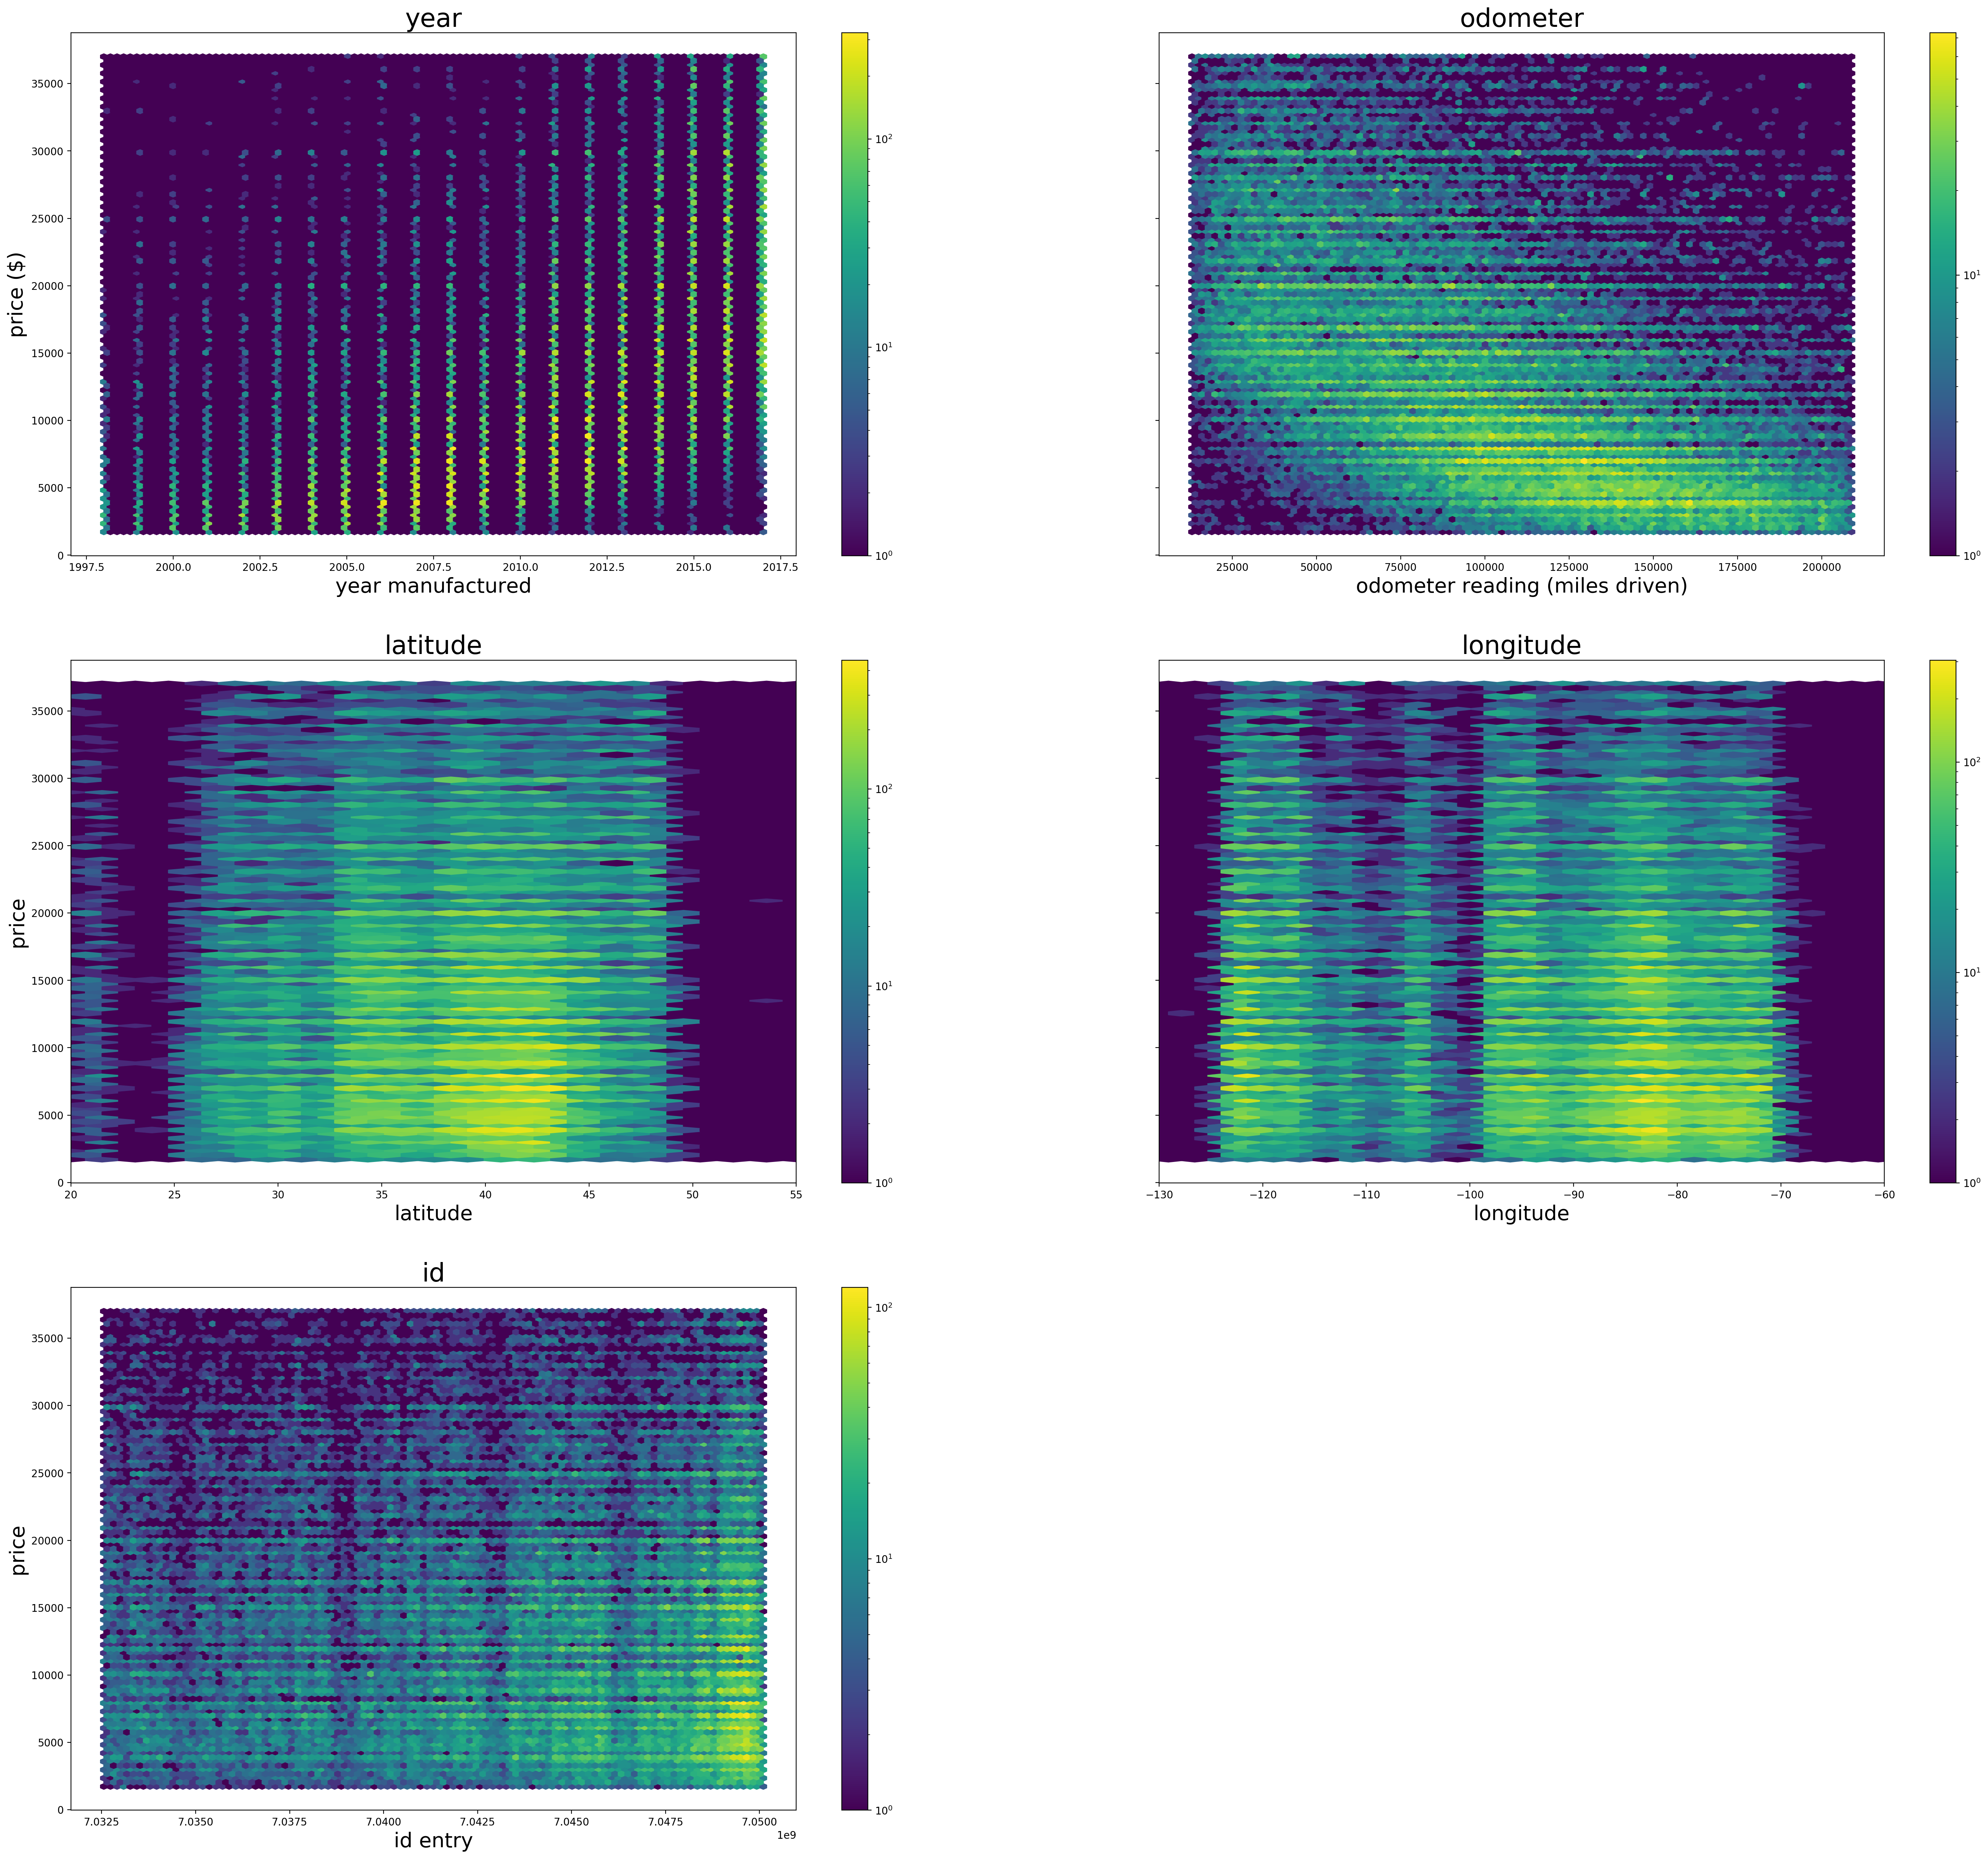

In [19]:
fig, ax = plt.subplots(3, 2, figsize=(35,32), dpi=200, sharey=True)
ax1, ax2, ax3, ax4, ax5, ax6 = ax.ravel()

a1 = ax1.hexbin(X['year'], price, bins='log')
ax1.set_title('year', fontsize=25)
ax1.set_xlabel('year manufactured',fontsize=20)
ax1.set_ylabel('price ($)',fontsize=20)
cb1= fig.colorbar(a1, ax=ax1, orientation='vertical')
a2 = ax2.hexbin(X['odometer'], price, bins='log')
ax2.set_title('odometer', fontsize=25)
ax2.set_xlabel('odometer reading (miles driven)',fontsize=20)
cb2= fig.colorbar(a2, ax=ax2, orientation='vertical')
a3 = ax3.hexbin(X['lat'], price, bins='log')
ax3.set_xlim(left=20,right=55)
ax3.set_title('latitude', fontsize=25)
ax3.set_ylabel('price',fontsize=20)
ax3.set_xlabel('latitude',fontsize=20)
cb3= fig.colorbar(a3, ax=ax3, orientation='vertical')
a4 = ax4.hexbin(X['long'], price, bins='log')
ax4.set_xlim(-130,-60)
ax4.set_title('longitude', fontsize=25)
ax4.set_xlabel('longitude',fontsize=20)
cb4= fig.colorbar(a4, ax=ax4, orientation='vertical')
a5 = ax5.hexbin(X['id'], price, bins='log')
ax5.set_title('id', fontsize=25)
ax5.set_ylabel('price',fontsize=20)
ax5.set_xlabel('id entry',fontsize=20)
cb5= fig.colorbar(a5, ax=ax5, orientation='vertical')
ax6.remove()
plt.show()
fig.tight_layout()

The above figures show that odometer and year are the only features that have a correlation with price. Odometer appears to have a negative linear correlation and year has a positive linear correlation. To receive clarity on whether odometer is related more to year of the car or the price it is graphed below in relation to both.  

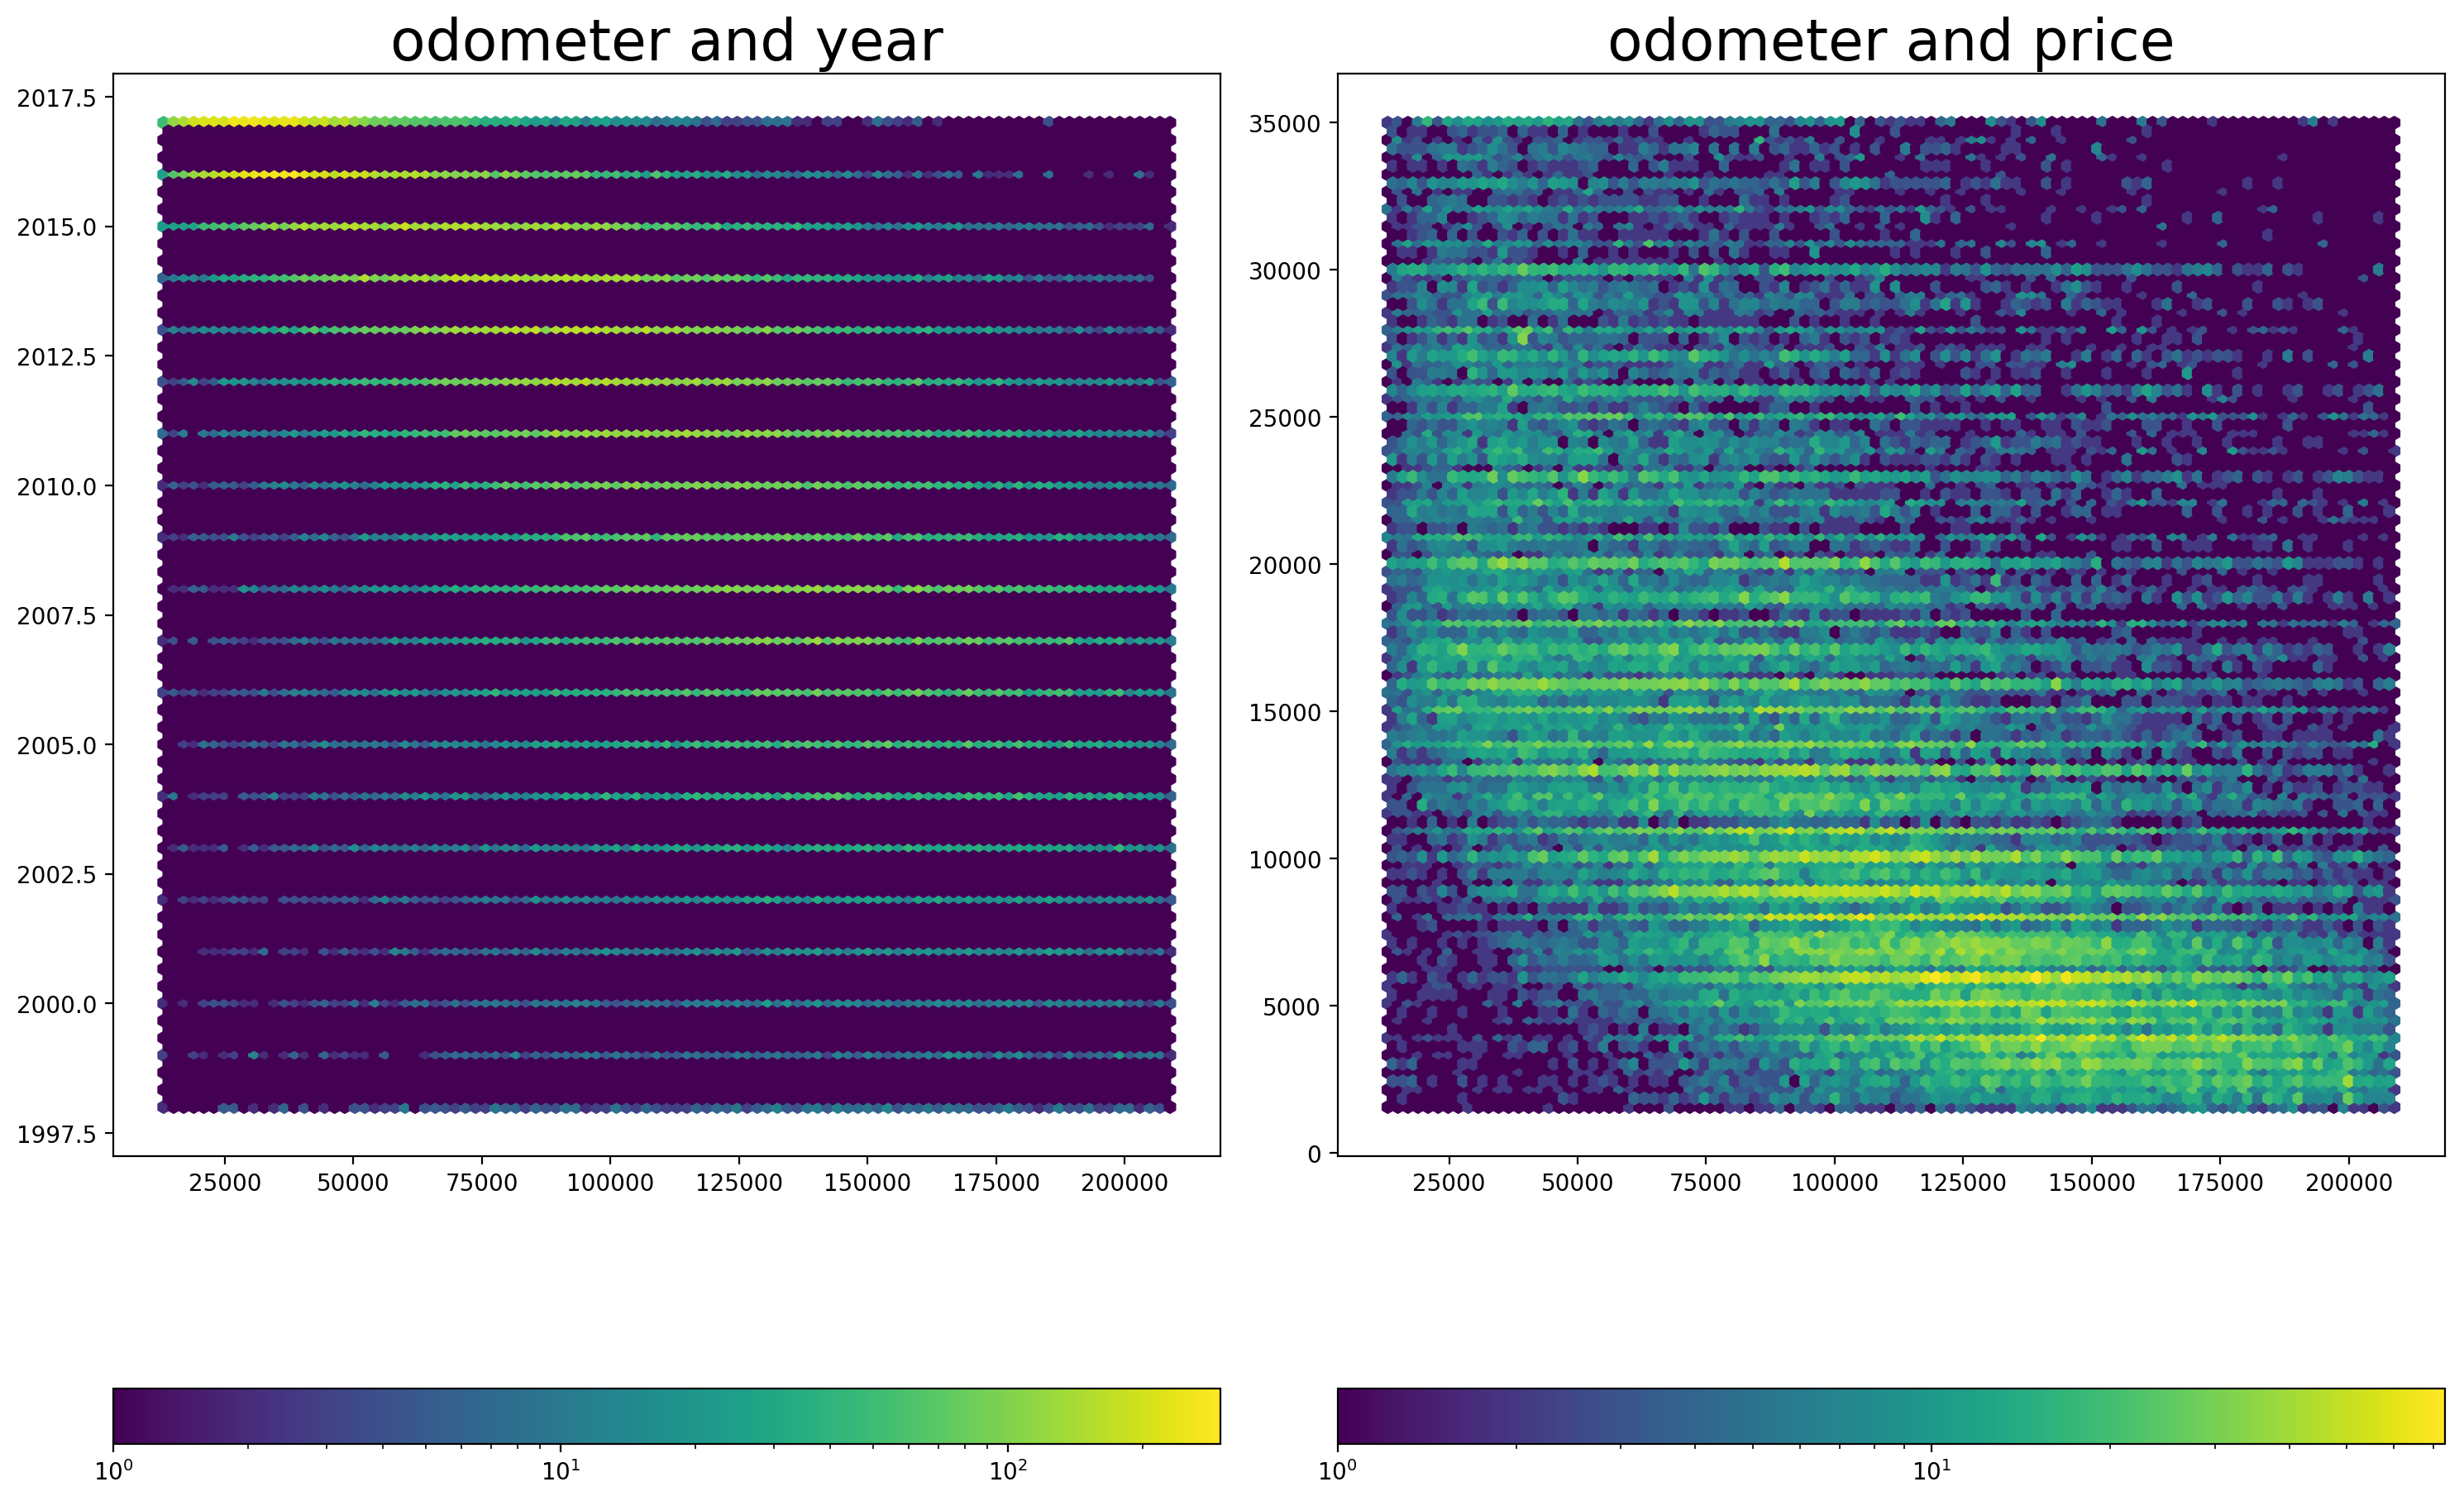

In [49]:
fig1, ax = plt.subplots(1,2, figsize=(15,10), dpi=200, sharex=True)
ax1, ax2 = ax.ravel()
a1 = ax1.hexbin(X['odometer'], X['year'], bins='log')
ax1.set_title('odometer and year', fontsize=25)
cb= fig1.colorbar(a1, ax=ax1, orientation='horizontal')
a2 = ax2.hexbin(X['odometer'], price, bins='log')
ax2.set_title('odometer and price', fontsize=25)
cb= fig1.colorbar(a2, ax=ax2, orientation='horizontal')
fig1.tight_layout()

Below is a graph that was created without removing outliers for the data. the X and Y limits have been zoomed in such that the trends are easier to see, but this demonstrates the nescesity of removing outliers from data. 

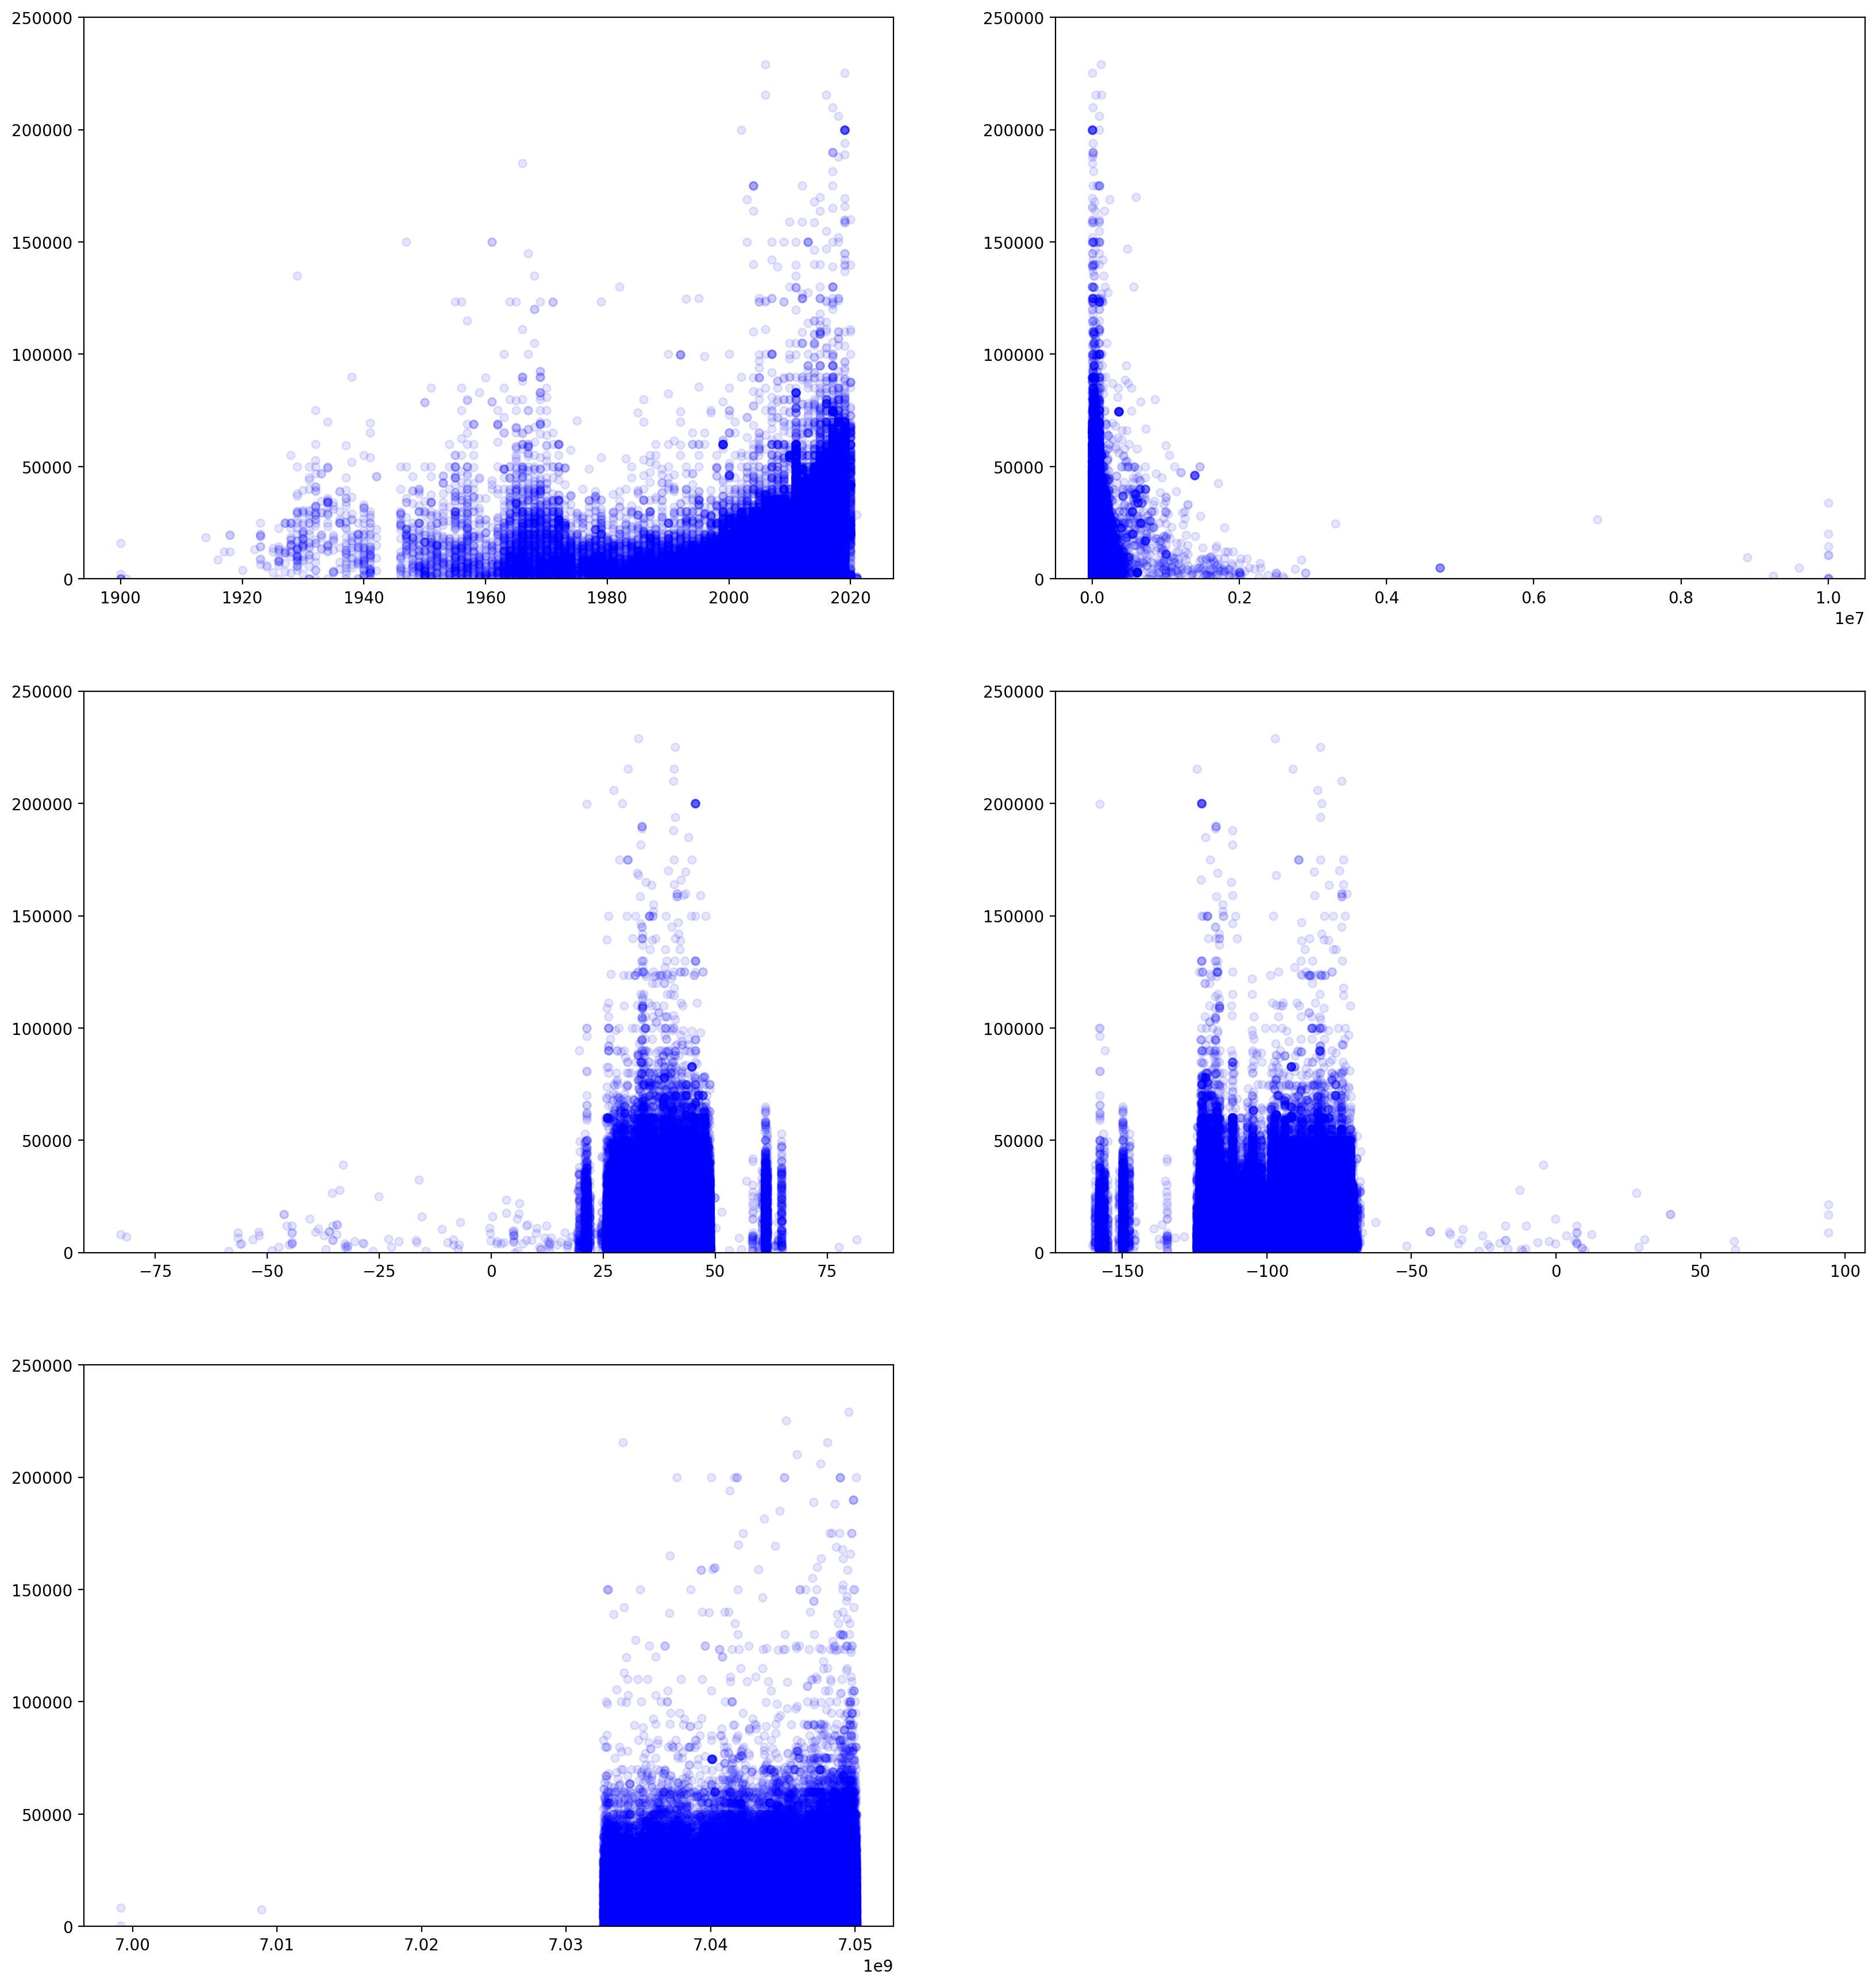

In [31]:
fig, ax = plt.subplots(3, 2, figsize=(20,22), dpi=200)
ax1, ax2, ax3, ax4, ax5, ax6 = ax.ravel()

ax1.plot(X['year'], price, 'bo', alpha=0.1, markersize=5)
ax1.set_ylim(-10, 0.00025E9)

ax2.plot(X['odometer'], price, 'bo', alpha=0.1, markersize=5)
ax2.set_ylim(-10, 0.00025E9)

ax3.plot(X['lat'], price, 'bo', alpha=0.1, markersize=5)
ax3.set_ylim(-10, 0.00025E9)

ax4.plot(X['long'], price, 'bo', alpha=0.1, markersize=5)
ax4.set_ylim(-10, 0.00025E9)

ax5.plot(X['id'], price, 'bo', alpha=0.1, markersize=5)
ax5.set_ylim(-10, 0.00025E9)

ax6.remove()
plt.show()

Next we decided to calculate the correlation between each of the continuous numerical features and the price in order to best quantify their possible relationhip. 

In [55]:
for col in data_float:
    print(f'Feature:  {col}')
    print(f'Correlation with price: {X[col].corr(price)}')

Feature:  id
Correlation with price: -0.044043957704703374
Feature:  year
Correlation with price: 0.5746757058012136
Feature:  odometer
Correlation with price: -0.5001498159469477
Feature:  lat
Correlation with price: 0.029264923397023638
Feature:  long
Correlation with price: -0.13665945026000342


In [56]:
# To see if odometer is more correlated with year or price
print('Feature: odometer')
print(f"Correlation with price: {X['odometer'].corr(price)}")
print(f"Correlation with year: {X['odometer'].corr(X['year'])}")

Feature: odometer
Correlation with price: -0.5001498159469477
Correlation with year: -0.5784874960406983


Calculate covariance values

In [57]:
cov = abs(X[data_float].corr().to_numpy())
order = np.array(hierarchy.dendrogram(hierarchy.ward(cov),no_plot=True)['ivl'], dtype=int)
sorted_keys = [data_float[x] for x in order]

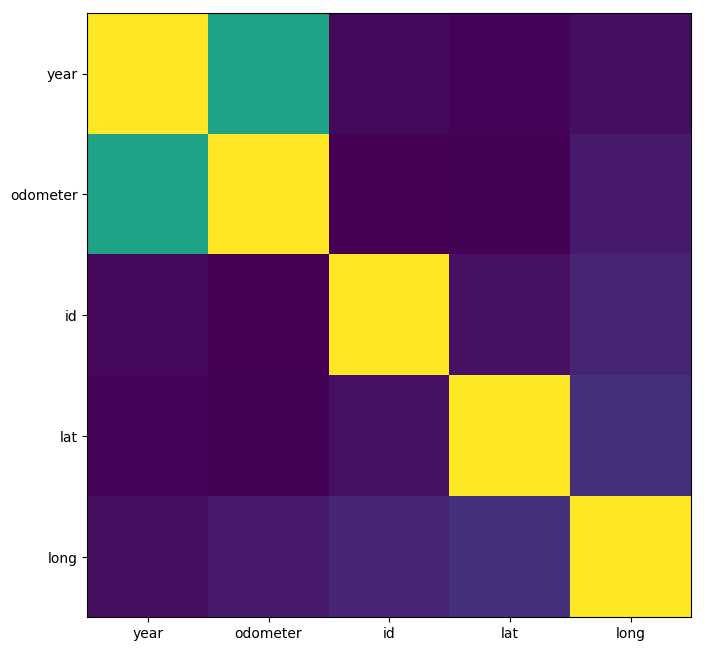

In [58]:
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(cov[order, :][:, order])
plt.xticks(range(len(sorted_keys)), sorted_keys)
plt.yticks(range(len(sorted_keys)), sorted_keys)
plt.show()

Based on the above results, we have decided to drop 'id' based on its graph and also on its correlation. we could also potentially drop odometer because it seems to be more correlated to year than price. we may also drop latitude and longitude as they display a fairly uniform distribution when plotted against the target, and are also correlated to one another. However, longitude and latitude could be useful geospatial data after some further feature engineering.

## Categorical Data: High Level Feature Analysis

In [23]:
def box(category):
    sns.set(style='whitegrid')
    ax = sns.boxplot(x=X[str(category)],y=price, showfliers = False)
    ax.set_title(f'{category} vs price', fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

In [27]:
def stripplot(category):
    plt.Figure()
    ax=plt.subplots(figsize=(15,6))
    ax = sns.stripplot(x= X[category], y=price)
    #ax.set_ylim(0, 150000)
    ax.set_xticklabels(X[category],rotation=90)
    ax.set_title(f'{category} vs price', fontsize=20)

In [51]:
#sort variables into continuous and categorical
continuous = []
categorical = []
for column in X.columns:
    if X[column].dtype == 'float':
        continuous.append(column)
    else:
        categorical.append(column)

In [52]:
cat_dict = {}
for cat in categorical:
    if len(X[cat].value_counts()) < 15:
        cat_dict[cat]= X['condition'].value_counts().values

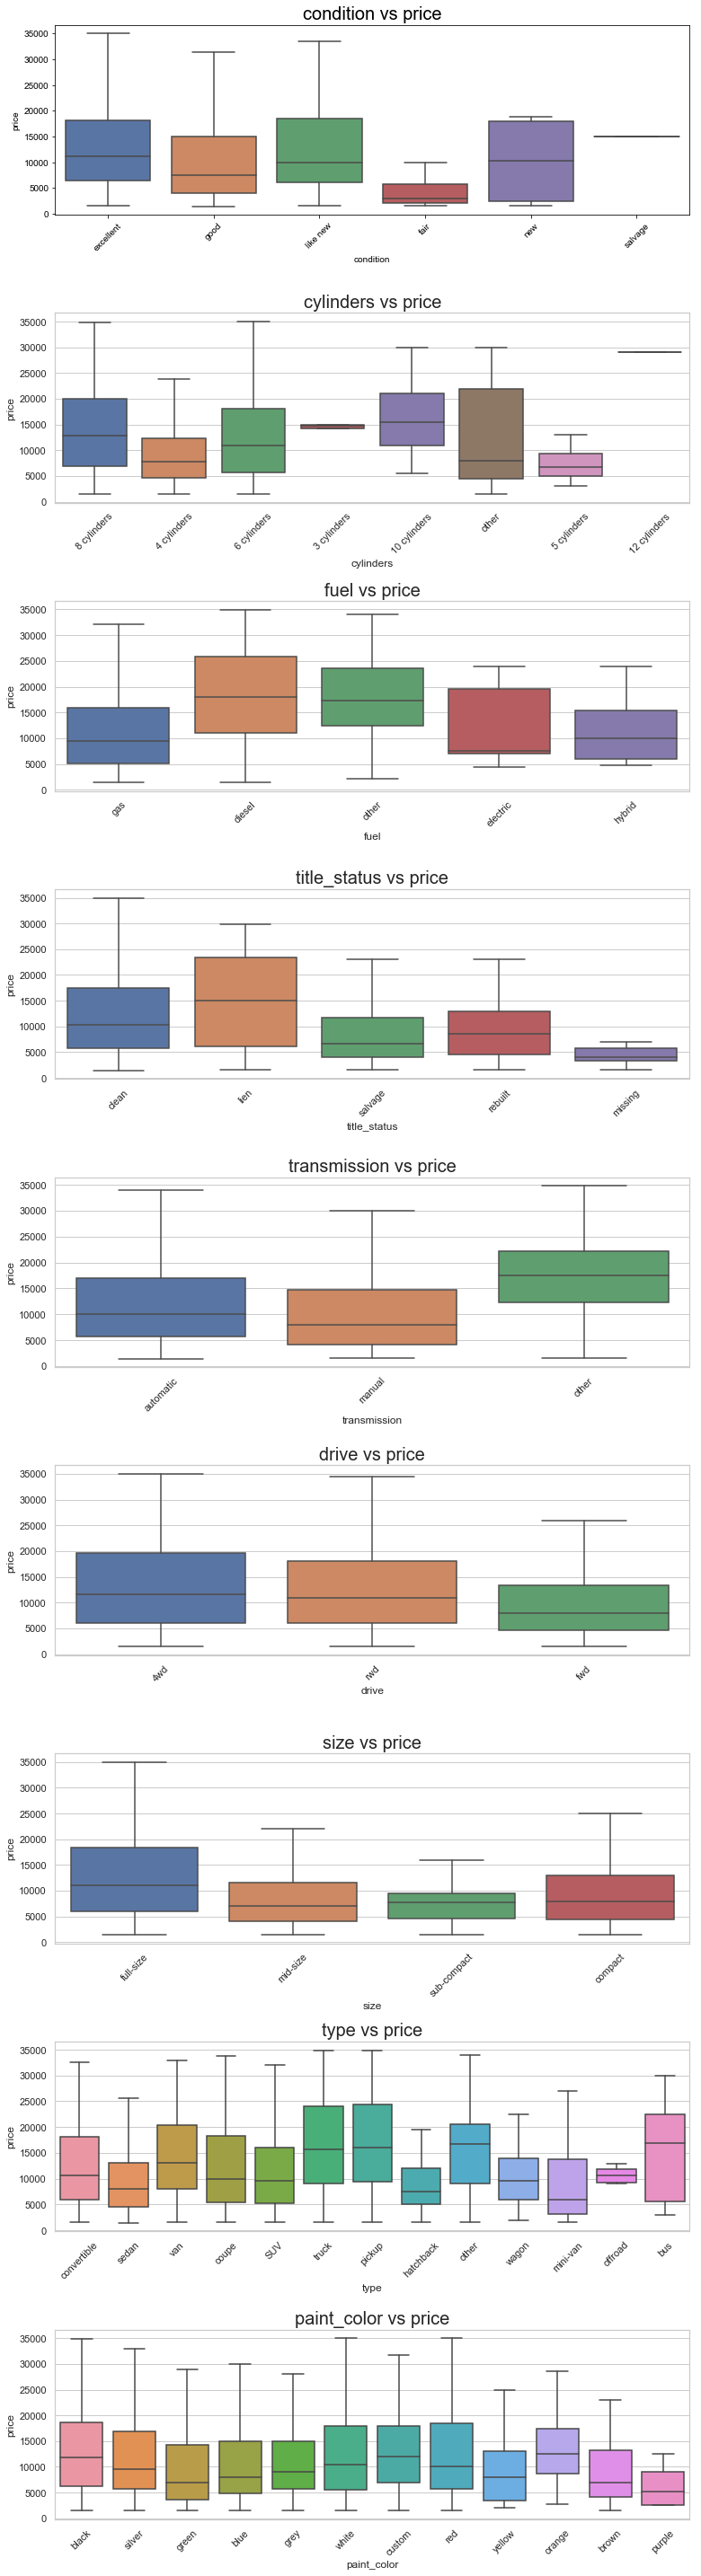

In [45]:
#NO OUTLIERS REMOVED
catfig = plt.figure(figsize=(11,40))
gs = catfig.add_gridspec(ncols=1,nrows=9)
i=0
for cat in categorical:
    if len(X[cat].value_counts()) < 15:
        ax = catfig.add_subplot(gs[i,0])
        i+=1
        box(cat)
catfig.tight_layout()

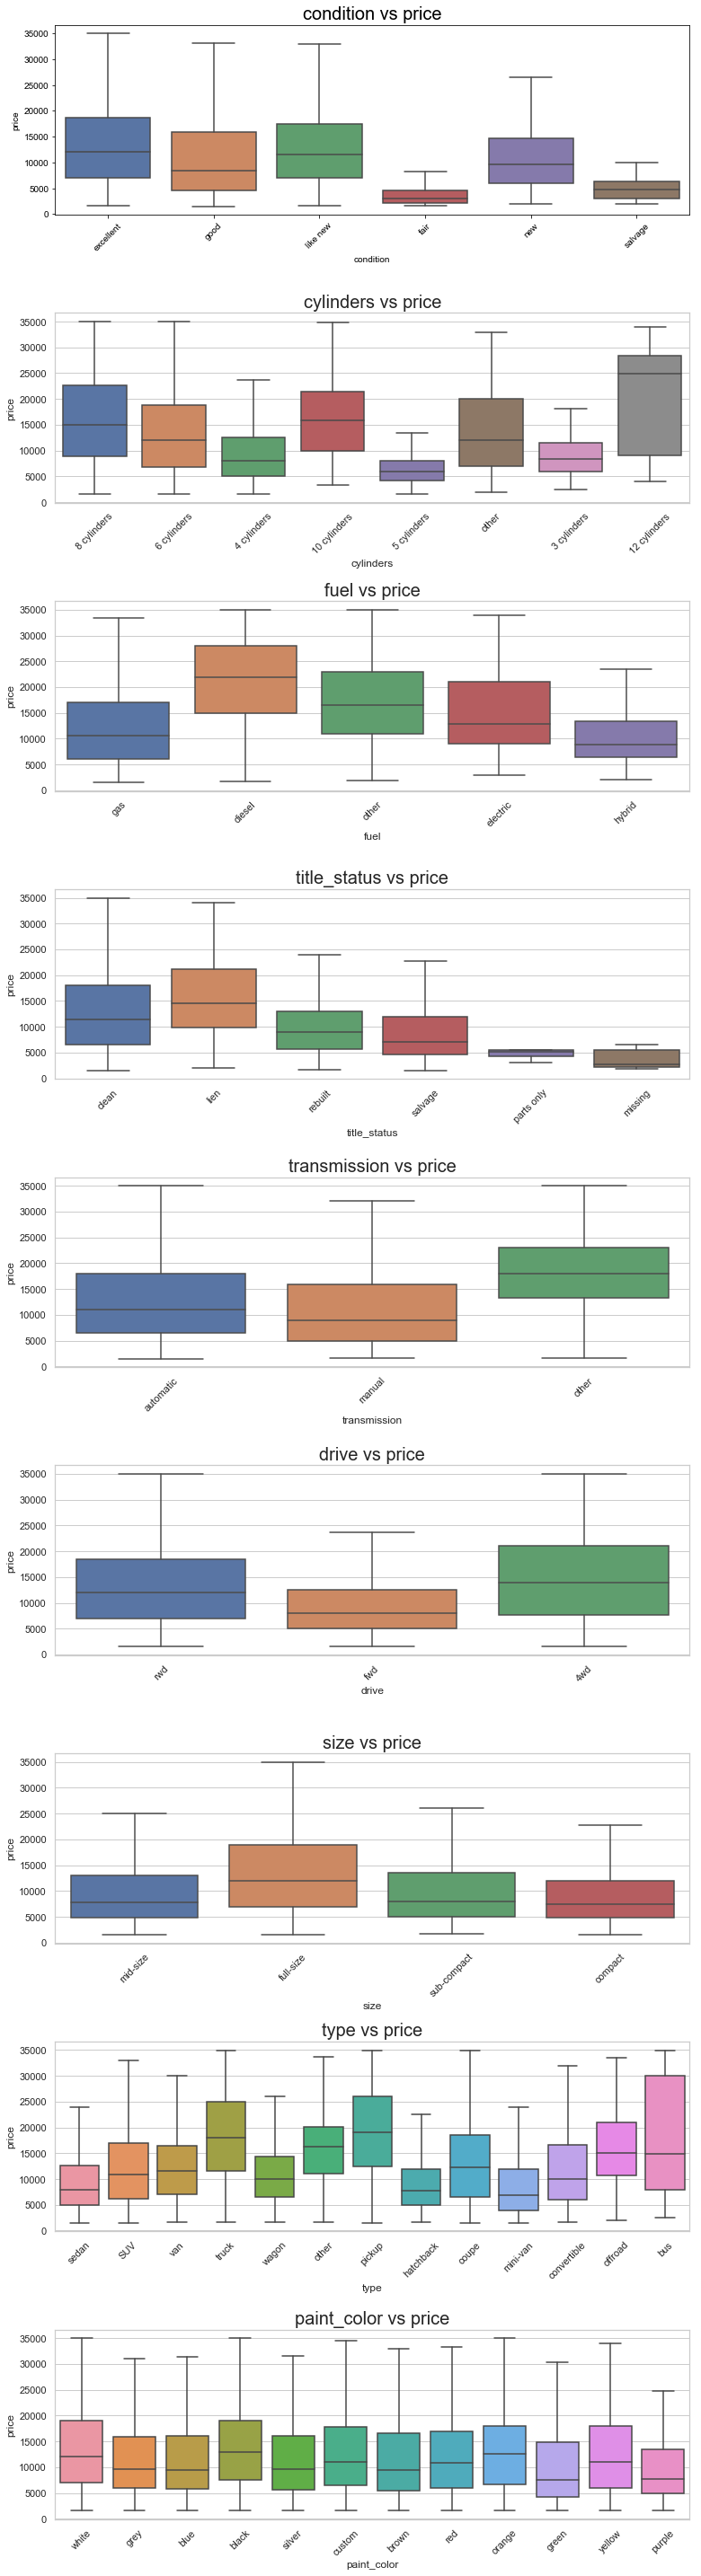

In [25]:
#OUTLIERS REMOVED
catfig = plt.figure(figsize=(11,40))
gs = catfig.add_gridspec(ncols=1,nrows=9)
i=0
for cat in categorical:
    if len(X[cat].value_counts()) < 15:
        ax = catfig.add_subplot(gs[i,0])
        i+=1
        box(cat)
catfig.tight_layout()

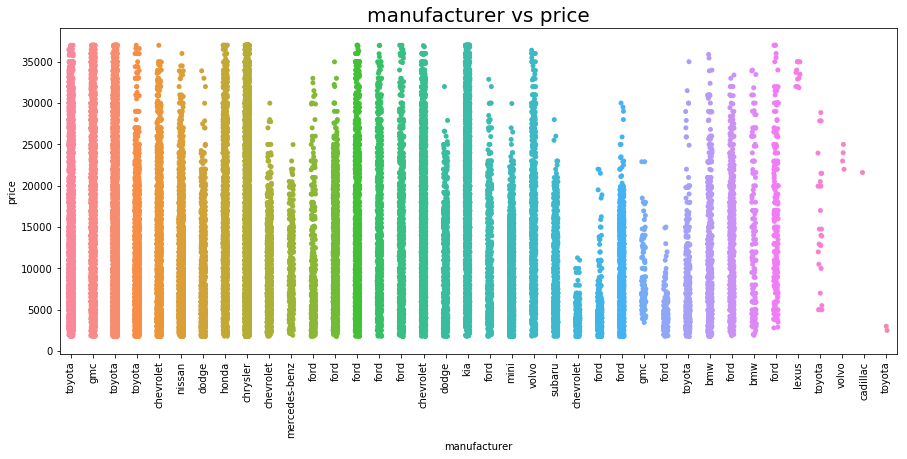

In [29]:
stripplot('manufacturer')

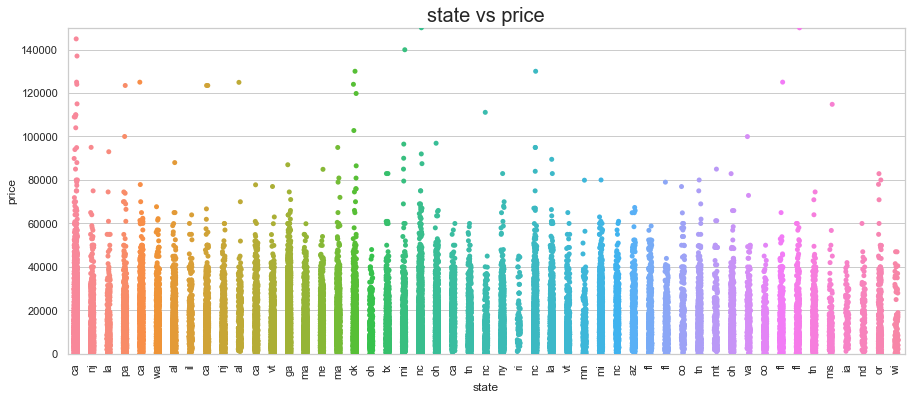

In [109]:
stripplot('state')

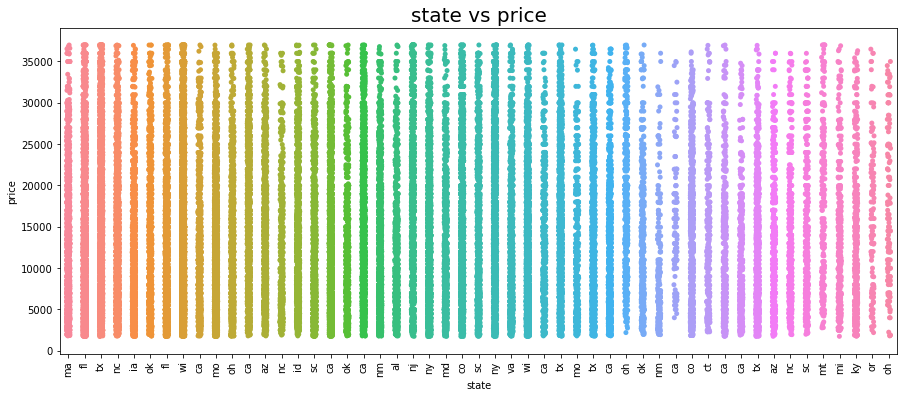

In [28]:
stripplot('state')


Text(0.5, 1.0, 'region vs price')

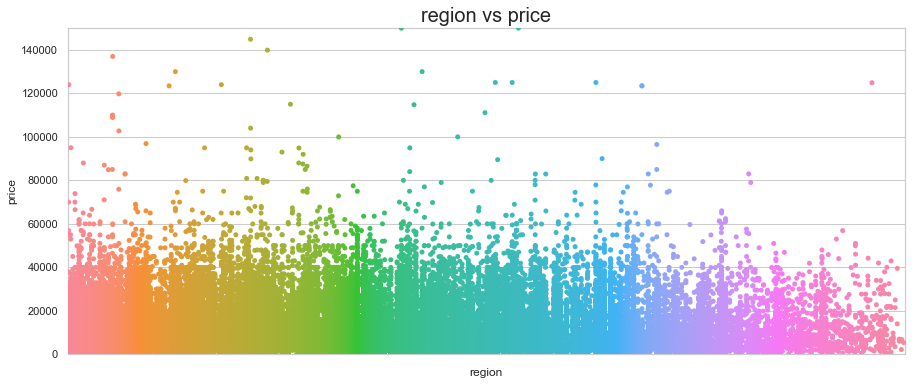

In [111]:
category='region'
plt.Figure()
ax=plt.subplots(figsize=(15,6))
ax = sns.stripplot(x= X[category], y=price)
ax.set_ylim(0, 150000)
ax.set_xticklabels([],rotation=90)
ax.set_title(f'{category} vs price', fontsize=20)

Text(0.5, 1.0, 'region vs price')

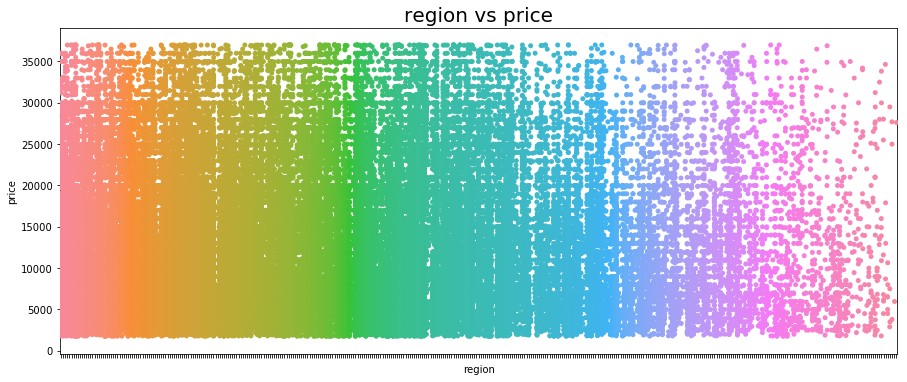

In [30]:
category='region'
plt.Figure()
ax=plt.subplots(figsize=(15,6))
ax = sns.stripplot(x= X[category], y=price)
#ax.set_ylim(0, 150000)
ax.set_xticklabels([],rotation=90)
ax.set_title(f'{category} vs price', fontsize=20)

Text(0.5, 1.0, 'model vs price')

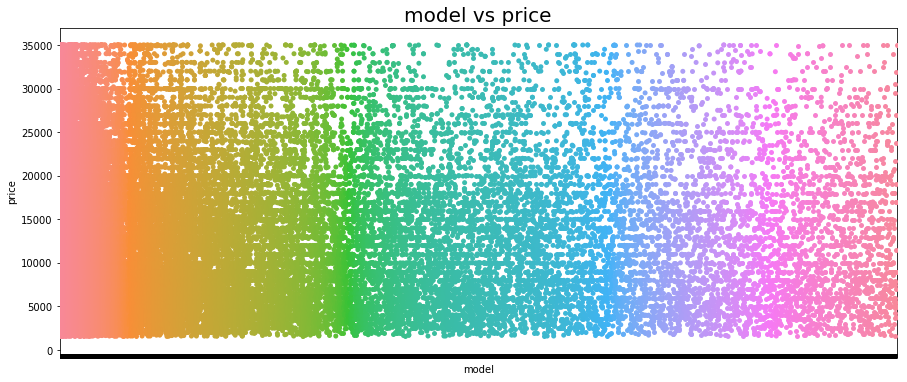

In [73]:
category='model'
plt.Figure()
ax=plt.subplots(figsize=(15,6))
ax = sns.stripplot(x= X[category], y=price)
ax.set_xticklabels([],rotation=90)
ax.set_title(f'{category} vs price', fontsize=20)

## Reflection from categorical plots:

The box plot graphs shown in the previous cells are box plots that show each category's relationship to the target: price. Because there are outliers in this data that make visualization difficult, we have chosen to remove them in this visulaization. As you can see, the plots that have the least correlation are paint color, type, and size, and the plot that reveals factors that are highly related are title status and cylinders. The plots look the same before and after removing outliers from the data, and that adds confidence that the removal of outliers has not affected the distribution of the data. 

In the stripplots you can see the difference in the data distribution before and after removing outliers. after this outleir removel state has the most uniform distribution. 

# Chi Squared Test

In [33]:
ordinal_encoder = preprocessing.OrdinalEncoder()
ordinal_encoder.fit(X[data_obj])
X_ordinal_noout = ordinal_encoder.transform(X[data_obj])

In [35]:
fs = SelectKBest(score_func=f_regression, k='all')
fs.fit(X_ordinal_noout, price)
scores_ = fs.scores_

In [36]:
score_feature_pairs = list(zip(fs.scores_, data_obj, fs.pvalues_))
sorted_list = sorted(score_feature_pairs)
for item in sorted_list:
    print(f'Category: {item[1]}, {item[0]}, {item[2]}')

Category: image_url, 1.2620692641690894, 0.2612634217869312
Category: state, 15.353289264990845, 8.924580074359055e-05
Category: paint_color, 20.229334188802067, 6.879594663623856e-06
Category: manufacturer, 21.98203419358575, 2.7570539707865937e-06
Category: model, 28.095147341756327, 1.158257245509819e-07
Category: region, 36.18054918986632, 1.8069895609812733e-09
Category: size, 204.8348437557279, 2.1231799187600793e-46
Category: transmission, 225.97236918946908, 5.361779935709795e-51
Category: type, 236.2126144778707, 3.184868254885343e-53
Category: title_status, 379.8898121354203, 2.1453015225955803e-84
Category: condition, 1035.2411013944618, 1.4393716026159937e-225
Category: fuel, 1765.9594187994326, 0.0
Category: drive, 2405.4618361265943, 0.0
Category: vin, 4433.686968739539, 0.0
Category: cylinders, 5304.642231199848, 0.0


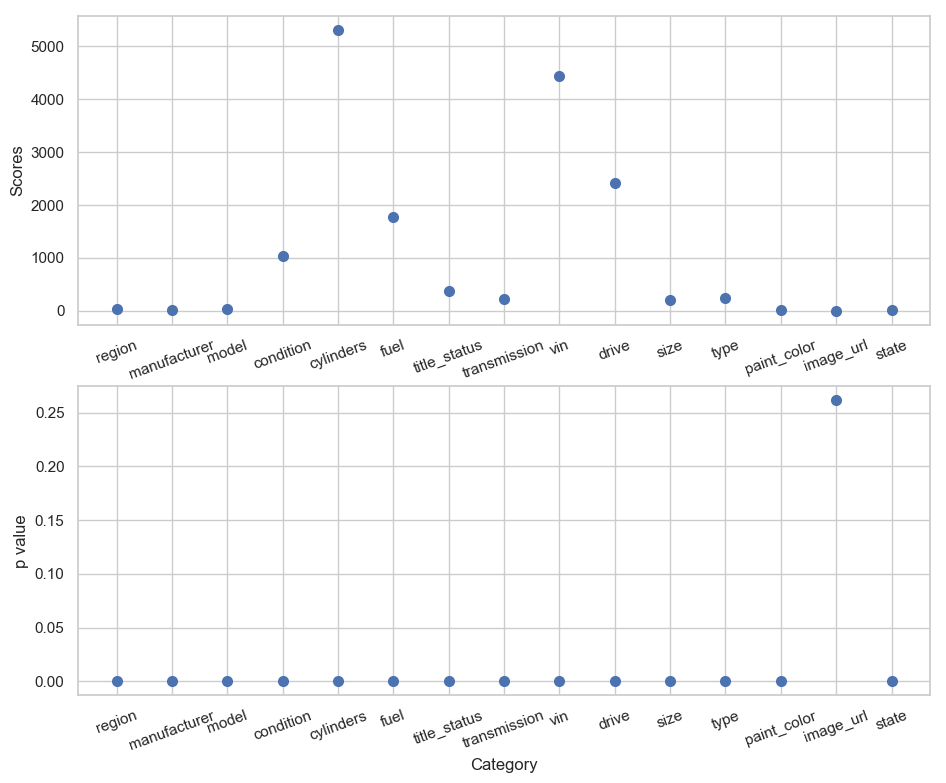

In [37]:
fig, ax = plt.subplots(2, 1, figsize=(11,9), dpi=100)
ax1, ax2 = ax.ravel()
ax1.plot(fs.scores_, 'bo', markersize=7)
ax1.set_xticks(range(len(data_obj)))
ax1.set_xticklabels(labels=data_obj, rotation=20)
ax1.set_ylabel('Scores')
ax1.set_xlabel('Category')

ax2.plot(fs.pvalues_, 'bo', markersize=7)
ax2.set_xticks(range(len(data_obj)))
ax2.set_xticklabels(labels=data_obj, rotation=20)
ax2.set_ylabel('p value')
ax2.set_xlabel('Category')
plt.show()

The chi-square test emphasizes the correlation with the categorical data. The features 'image_url', 'state', and 'paint_color' have the lowest corelation with price and therefore, can likely be dropped going forward.

## Task 1 Final thoughts:

- dropping bottom 3 features in the chai squared test: image_url, state, paint_color
- dropping bottom 3 features with covariance test: id, lat, long
- dropping feature with highest p value: image_url
- dropping feature with possible data leaking: vin

From all of the initial data exploration we have decided to drop the following columns:
['id', 'vin', 'image_url', 'state','paint_color', 'lat', 'long'] with odometer as a possible column to drop as it shows a higher correlation with 'year' than 'price' which is the target. 

# Task 2

In [58]:
#dropping odometer 
rows_to_drop= ['id', 'vin', 'image_url', 'state','paint_color', 'lat','long','odometer']

In [17]:
# not droppign odometer
rows_to_drop_2 = ['id', 'vin', 'image_url', 'state','paint_color', 'lat', 'long']

In [60]:
X_drop1 = X.drop(columns=rows_to_drop)

In [18]:
X_drop_2 = X.drop(columns=rows_to_drop_2)

### Odometer Dropped

In [22]:
#Original
X_train, X_test, y_train, y_test = train_test_split(X_drop1, price, shuffle=True, random_state=0)
cv_strategy = KFold(n_splits=10, shuffle=True, random_state=5)

In [23]:
# Remove features which were dropped
data_obj_refined = [x for x in data_obj if x not in rows_to_drop]
data_float_refined = [x for x in data_float if x not in rows_to_drop]

# Define the features to target encode and remove them from the data_obj_refined list
target_encode = ['model', 'region', 'manufacturer']
data_obj_refined = [x for x in data_obj_refined if x not in target_encode]

Simple pre-processing and encoding on the selected features

In [24]:
target_encoding = make_pipeline(TargetEncoder(), preprocessing.StandardScaler())
cat_encoding = Pipeline([('encode', preprocessing.OneHotEncoder(handle_unknown='ignore'))]) 
cont_encoding = Pipeline([('scale', preprocessing.StandardScaler())])
processing_pipe = make_column_transformer((target_encoding, target_encode),
                                        (cont_encoding, data_float_refined),
                                        (cat_encoding, data_obj_refined), 
                                        remainder='passthrough')

Minimal viable models

In [25]:
ridge_pipe = make_pipeline(processing_pipe, Ridge())
scores = cross_val_score(ridge_pipe, X_train, y_train, cv=cv_strategy)
np.mean(scores)

0.7034006746796773

In [26]:
lasso_pipe = make_pipeline(processing_pipe, Lasso(max_iter=5000))
scores = cross_val_score(lasso_pipe, X_train, y_train, cv=cv_strategy)
np.mean(scores)

0.7034012065707789

### Odometer not dropped

In [350]:
#Odometer not dropped 
X_train, X_test, y_train, y_test = train_test_split(X_drop_2, price, shuffle=True, random_state=0)
cv_strategy = KFold(n_splits=10, shuffle=True, random_state=5)

In [351]:
# Remove features which were dropped
data_obj_refined = [x for x in data_obj if x not in rows_to_drop_2]
data_float_refined = [x for x in data_float if x not in rows_to_drop_2]

# Define the features to target encode and remove them from the data_obj_refined list
target_encode = ['model', 'region', 'manufacturer']
data_obj_refined = [x for x in data_obj_refined if x not in target_encode]

In [352]:
target_encoding = make_pipeline(TargetEncoder(), preprocessing.StandardScaler())
cat_encoding = Pipeline([('encode', preprocessing.OneHotEncoder(handle_unknown='ignore'))]) 
cont_encoding = Pipeline([('scale', preprocessing.StandardScaler())])
processing_pipe = make_column_transformer((target_encoding, target_encode),
                                        (cont_encoding, data_float_refined),
                                        (cat_encoding, data_obj_refined), 
                                        remainder='passthrough')

Minimal viable models

In [22]:
ridge_pipe = make_pipeline(processing_pipe, Ridge())
scores = cross_val_score(ridge_pipe, X_train, y_train, cv=cv_strategy)
np.mean(scores)

0.7536441060793255

In [21]:
lasso_pipe = make_pipeline(processing_pipe, Lasso(max_iter=5000))
scores = cross_val_score(lasso_pipe, X_train, y_train, cv=cv_strategy)
np.mean(scores)

0.7566488110430528

Because the crossval scores keeping the odometer feature are 5% higher than those dropping the odometer feature, we have decided to keep this feature moving forward. The total list of dropped featuers is therefore ['id', 'vin', 'image_url', 'state','paint_color', 'lat', 'long'] due to poor performances in teh Chai sqaured test, or lack of correlation to price when graphed. These tests can be seen in Task 1 and a summary can be found in Task 1 Final Thoughts. 

In [354]:
X_geo = X[['lat','long']]
X = X_drop_2

# Task 3

in this section we will try a variety of pre-processing techniques, and then using the best pipeline we will try more involved feature engineering. 
Section Overview:
- Robust scaling
- ordinal encoding
- polynomial features encoding
- sum encoding 


In [129]:
def graph_cv_results(lasso_metrics,ridge_metrics):

    #FINAL METRICE BEFORE GRID SEARCH
    cvs_fig, ax = plt.subplots(1, 2, figsize=(15,5),sharex=True, sharey=True)
    ax1, ax3, = ax.ravel()

    ax1.plot(lasso_metrics['train_score'], color='blue')
    ax1.plot(lasso_metrics['test_score'], color='orange')
    ax1.set_title(f'Cross Validation Scores for Lasso', fontsize=20)
    ax1.set_xlabel('fold', fontsize=15)
    ax1.set_ylabel('score out of 1.0', fontsize=15)
    ax1.legend(['train_score','test_score'])
    #sns.boxplot(data = poly_lasso_scores, orient='h',ax=ax2)
    ax3.plot(ridge_metrics['train_score'], color='blue')
    ax3.plot(ridge_metrics['test_score'], color='orange')
    ax3.set_title(f'Cross Validation Scores for Ridge', fontsize=20)
    ax3.set_xlabel('fold', fontsize=15)
    ax3.set_ylabel('score out of 1.0', fontsize=15)
    ax3.legend(['train_score','test_score'])
    #sns.boxplot(data = poly_ridge_scores, orient='h',ax=ax4)
    cvs_fig.tight_layout()

### Robust Scaling
Trying Robust scaling to determine the effect of any remaining outliers, as opposed to standard scaling.

In [355]:
#Trying Robust Scaling to see if there are any remaining outliers
target_encoding = make_pipeline(TargetEncoder(), preprocessing.RobustScaler())
cat_encoding = Pipeline([('encode', preprocessing.OneHotEncoder(handle_unknown='ignore'))]) 
cont_encoding = Pipeline([('scale', preprocessing.RobustScaler())])
processing_pipe = make_column_transformer((target_encoding, target_encode),
                                        (cont_encoding, data_float_refined),
                                        (cat_encoding, data_obj_refined), 
                                        remainder='passthrough')

In [46]:
ridge_pipe = make_pipeline(processing_pipe, Ridge())
robust_ridge_metrics = cross_validate(ridge_pipe, X_train, y_train, cv=cv_strategy, return_train_score=True)
print(f'The mean score is {np.mean(robust_ridge_metrics["test_score"])} , the standard deviation is {np.std(robust_ridge_metrics["test_score"])}')

The mean score is 0.7577753696550464 , the standard deviation is 0.00416869927796533


In [47]:
lasso_pipe = make_pipeline(processing_pipe, Lasso(max_iter=5000))
robust_lasso_metrics = cross_validate(lasso_pipe, X_train, y_train, cv=cv_strategy, return_train_score=True)
print(f'The mean score is {np.mean(robust_lasso_metrics["test_score"])} , the standard deviation is {np.std(robust_lasso_metrics["test_score"])}')

The mean score is 0.7576532904077864 , the standard deviation is 0.004222059483367105


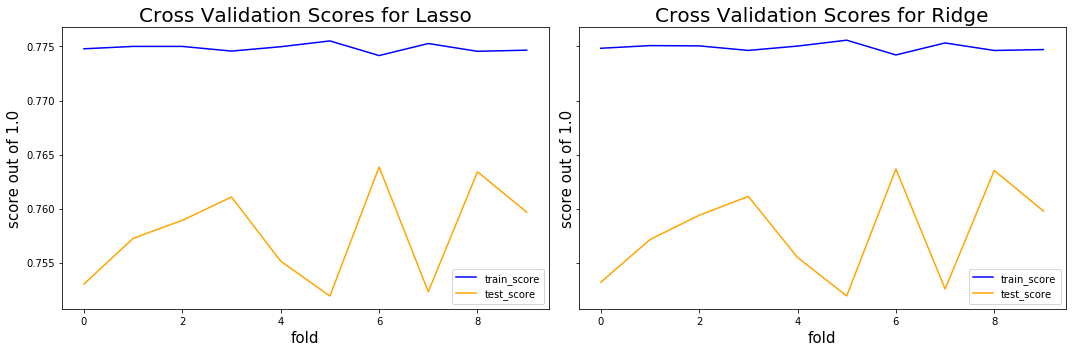

In [48]:
graph_cv_results(robust_lasso_metrics, robust_ridge_metrics)

The scores for Ridge and Lasso are not changed from task 2, this is likely because the outliers have already been removed.

### Ordinal Encoding
Looking at Ordinal Encoding for features that are in a heiarchy or ordered ranking to see if the scores are able to improve

In [443]:
ordinal_cols_mapping = [{
    "col":"cylinders",    
    "mapping": {
        '12 cylinders': 7, 
        '10 cylinders': 6, 
        '8 cylinders': 5, 
        '6 cylinders': 4, 
        '5 cylinders': 3, 
        '4 cylinders': 2,
        '3 cylinders': 1,
        'other': 0
    }},
    {"col":"condition",
     "mapping": {
         'new': 5,
         'like new': 4,
         'excellent': 3,
         'good': 2,
         'fair': 1,
         'salvage': 0
     }},
    {"col":"size",
     "mapping": {
         'full-size': 3,
         'mid-size': 2,
         'compact': 1,
         'sub-compact': 0
    }},
    {"col":"title_status",
     "mapping": {
         'dean': 0,
         'lein': 1,
         'rebuilt': 2,
         'salvage': 3,
         'parts only': 4,
         'missing': 5
    }
}]

In [444]:
to_ordinal_encode = ['cylinders', 'condition', 'size', 'title_status']
ordinal_encoding = make_pipeline(OrdinalEncoder(mapping=ordinal_cols_mapping), preprocessing.StandardScaler())
data_obj_refined = [x for x in data_obj_refined if x not in to_ordinal_encode]

In [445]:
target_encoding = make_pipeline(TargetEncoder(), preprocessing.StandardScaler())
cat_encoding = Pipeline([('encode', preprocessing.OneHotEncoder(handle_unknown='ignore'))]) 
cont_encoding = Pipeline([('scale', preprocessing.StandardScaler())])
ordinal_processing_pipe = make_column_transformer((target_encoding, target_encode),
                                        (ordinal_encoding, to_ordinal_encode),
                                        (cont_encoding, data_float_refined),
                                        (cat_encoding, data_obj_refined), 
                                        remainder='passthrough')

In [52]:
ridge_pipe_with_ordinal = make_pipeline(ordinal_processing_pipe, Ridge())
ordinal_ridge_metrics = cross_validate(ridge_pipe_with_ordinal, X_train, y_train, cv=cv_strategy, return_train_score=True)
print(f'The mean score is {np.mean(scores)} , the standard deviation is {np.std(scores)}')

The mean score is 0.7576529333843716 , the standard deviation is 0.004222722666363072


In [53]:
lasso_pipe_with_ordinal = make_pipeline(ordinal_processing_pipe, Lasso(max_iter=5000))
ordinal_lasso_metrics = cross_validate(lasso_pipe_with_ordinal, X_train, y_train, cv=cv_strategy, return_train_score=True)
print(f'The mean score is {np.mean(scores)} , the standard deviation is {np.std(scores)}')

The mean score is 0.7576529333843716 , the standard deviation is 0.004222722666363072


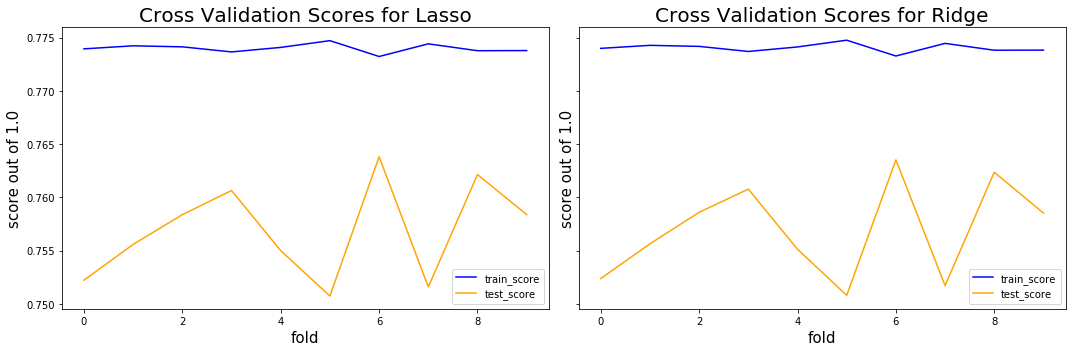

In [54]:
graph_cv_results(ordinal_lasso_metrics, ordinal_ridge_metrics)

Based on the cross-validation results, neither model shows significant change. However, ordinal encoding reduces the number of features that linear models are required to fit to, compared to one-hot encoding. Therefore, ordinal encoding will be used further.

### Polynomial Features 
The next section shows the affects of using polynomial features.

In [361]:
target_encoding = make_pipeline(TargetEncoder(), preprocessing.StandardScaler())
ordinal_encoding = make_pipeline(OrdinalEncoder(mapping=ordinal_cols_mapping), preprocessing.StandardScaler(), preprocessing.PolynomialFeatures(degree=3))
cont_encoding = Pipeline([('scale', preprocessing.StandardScaler()), ('poly', preprocessing.PolynomialFeatures(degree=3))])
poly_processing_pipe = make_column_transformer((target_encoding, target_encode),
                                        (ordinal_encoding, to_ordinal_encode),
                                        (cont_encoding, data_float_refined),
                                        (cat_encoding, data_obj_refined), 
                                        remainder='passthrough')

In [56]:
ridge_pipe_with_poly = make_pipeline(poly_processing_pipe, Ridge(alpha=100))
poly_ridge_metrics = cross_validate(ridge_pipe_with_poly, X_train, y_train, cv=cv_strategy, return_train_score=True)
print(f"The mean score is {np.mean(poly_ridge_metrics['test_score'])} , the standard deviation is {np.std(poly_ridge_metrics['test_score'])}")

The mean score is 0.7673199939008861 , the standard deviation is 0.004727226734886778


In [57]:
lasso_pipe_with_poly = make_pipeline(poly_processing_pipe, Lasso(max_iter=5000))
poly_lasso_metrics = cross_validate(ridge_pipe_with_poly, X_train, y_train, cv=cv_strategy, return_train_score=True)
print(f'The mean score is {np.mean(poly_lasso_metrics["test_score"])} , the standard deviation is {np.std(poly_lasso_metrics["test_score"])}')

The mean score is 0.7673199939008861 , the standard deviation is 0.004727226734886778


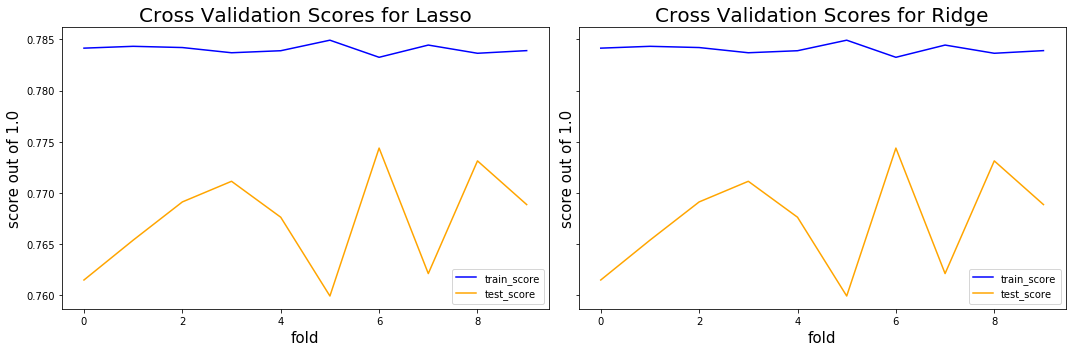

In [58]:
graph_cv_results(poly_lasso_metrics, poly_ridge_metrics)

Polynomial features seems to assist in the model's skill, resulting in a higher cross-validation score.

### Sum Encoding
After trying multiple packages not discussed in calss from sklearn category_encoders, the most successful was sum contrast encoding (shown below) however the scores did not change significantly from using one hot encoding so the change was not made to use sum encoding moving forward. Also, often convergence issues were found with this type of encoding. Therefore the pipiline moving forward is the poly_processing_pipe. 

In [72]:
#sum contrast encoding 
from category_encoders import SumEncoder
sum_encoding = make_pipeline(SumEncoder(data_obj_refined))
# http://contrib.scikit-learn.org/categorical-encoding/sum.html

In [73]:
target_encoding = make_pipeline(TargetEncoder(), preprocessing.StandardScaler())
ordinal_encoding = make_pipeline(OrdinalEncoder(mapping=ordinal_cols_mapping), preprocessing.StandardScaler(), preprocessing.PolynomialFeatures(degree=3))
cont_encoding = Pipeline([('scale', preprocessing.StandardScaler()), ('poly', preprocessing.PolynomialFeatures(degree=3))])
sum_processing_pipe = make_column_transformer((target_encoding, target_encode),
                                        (ordinal_encoding, to_ordinal_encode),
                                        (cont_encoding, data_float_refined),
                                        (sum_encoding, data_obj_refined), 
                                        remainder='passthrough')

In [61]:
ridge_pipe_with_sum = make_pipeline(sum_processing_pipe, Ridge(alpha=2))
sum_ridge_metrics = cross_validate(ridge_pipe_with_sum, X_train, y_train, cv=cv_strategy, return_train_score=True)
print(f'The mean score is {np.mean(sum_ridge_metrics["test_score"])} , the standard deviation is {np.std(sum_ridge_metrics["test_score"])}')

The mean score is 0.7676027993116111 , the standard deviation is 0.004683327929506839


In [62]:
lasso_pipe_with_sum = make_pipeline(sum_processing_pipe, Lasso(max_iter=50000))
sum_lasso_metrics = cross_validate(lasso_pipe_with_sum, X_train, y_train, cv=cv_strategy, return_train_score=True)
print(f'The mean score is {np.mean(scores)} , the standard deviation is {np.std(scores)}')

The mean score is 0.7576529333843716 , the standard deviation is 0.004222722666363072


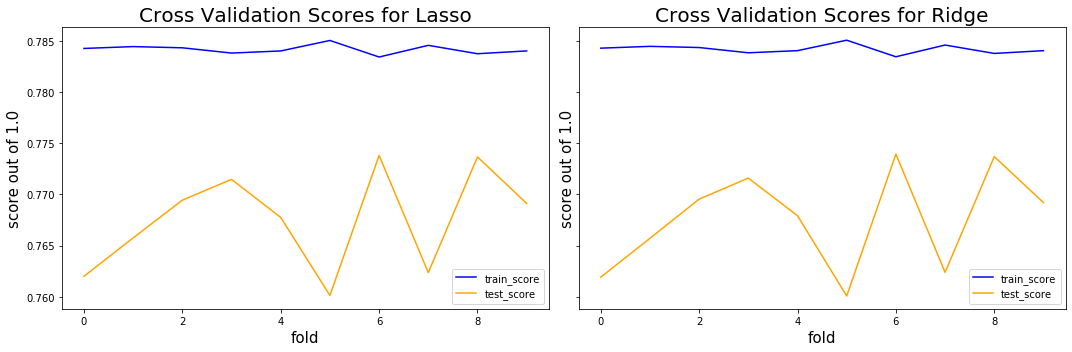

In [63]:
graph_cv_results(sum_lasso_metrics,sum_ridge_metrics)

## Geospatial Feature Engineering 

In this section we were planning on using outside datat for geospatial feature engineering. As this is not allowed (as shown in a piazza post) the level of feature engineering that we can complete is rather limited. 
1. Here we divide the country into the two coasts and the center of the country in case weather patters have anything to do with the price of used cars. 
2. We used a ranking metric of the bikability, public transport, and walkability of a city as an ordinal encoding score. this represents whether or not people have an alternative to owning a car in that city. 

If we were allowed to use outside databases we would have tried:
1. mapping the latitude/longitude to the 'rust belt' or other gepgraphical features of the country
2. converting the latitude/longitude to the distance from the largest city in the region 

In [74]:
west_coast = 115
east_coast = 80

In [75]:
us_region = []
for row in X_geo['long']:
    if abs(row) >= west_coast:
        row = 'west'
    elif abs(row) <= east_coast:
        row = 'east'
    else:
        row = 'mid'
    us_region.append(row)

In [101]:
x_train_geo = X_train.join(X_geo, how='left')
x_train_geo = x_train_geo.drop(columns=['lat','long'])

In [102]:
data_obj = [col for col in x_train_geo.columns if x_train_geo[col].dtype == 'object']
data_float = [col for col in x_train_geo.columns if x_train_geo[col].dtype != 'object']
# data_float_refined.remove('lat')
# data_float_refined.remove('long')
data_obj_refined.append('us_region')

In [104]:
cat_encoding = Pipeline([('encode', preprocessing.OneHotEncoder(handle_unknown='ignore'))]) 
target_encoding = make_pipeline(TargetEncoder(), preprocessing.StandardScaler())
ordinal_encoding = make_pipeline(OrdinalEncoder(mapping=ordinal_cols_mapping), preprocessing.StandardScaler(), preprocessing.PolynomialFeatures(degree=3))
cont_encoding = Pipeline([('scale', preprocessing.StandardScaler()), ('poly', preprocessing.PolynomialFeatures(degree=3))])
coast_processing_pipe = make_column_transformer((target_encoding, target_encode),
                                        (ordinal_encoding, to_ordinal_encode),
                                        (cont_encoding, data_float_refined),
                                        (cat_encoding, data_obj_refined), 
                                        remainder='passthrough')

In [105]:
ridge_pipe_with_coast = make_pipeline(coast_processing_pipe, Ridge())
coast_ridge_metrics = cross_validate(ridge_pipe_with_coast, x_train_geo, y_train, cv=cv_strategy, return_train_score=True)
print(f"The mean score is {np.mean(coast_ridge_metrics['test_score'])} , the standard deviation is {np.std(coast_ridge_metrics['test_score'])}")

The mean score is 0.762408500267703 , the standard deviation is 0.004966961849528364


In [106]:
lasso_pipe_with_coast = make_pipeline(coast_processing_pipe, Lasso(max_iter=50000))
coast_lasso_metrics = cross_validate(lasso_pipe_with_coast, x_train_geo, y_train, cv=cv_strategy, return_train_score=True)
print(f"The mean score is {np.mean(coast_lasso_metrics['test_score'])} , the standard deviation is {np.std(coast_lasso_metrics['test_score'])}")

The mean score is 0.7623353804843911 , the standard deviation is 0.004999927517052011


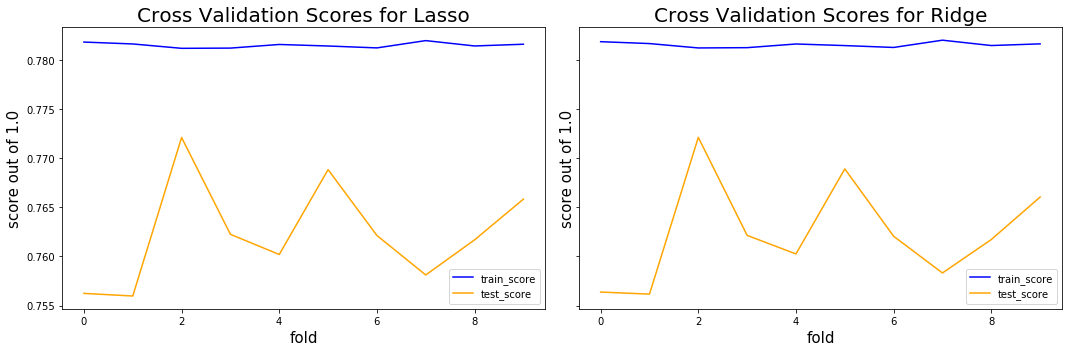

In [107]:
graph_cv_results(coast_lasso_metrics, coast_ridge_metrics)

### Commute Alternatives

We will now look at commute alternatives, e.g. replacing region data with the ranking of the city's public transport.

In [108]:
bike_csv = pd.read_csv('bikeability.csv')

In [109]:
city_list_dict = {}
cities = []
for city in bike_csv.iterrows():
    cities.append(city[1][0].lower())
    city_list_dict[str(city[1][0].lower())] =  int(city[0])
    
alternative_commute = []
for x in x_train_geo['region']:
    x.lower()
    if x in cities: 
        alternative_commute.append(city_list_dict[x])
    else:
        alternative_commute.append(0)

In [110]:
x_train_geo['alternative_commute'] = alternative_commute
X_geo_bike = x_train_geo.drop(columns=['region'])

In [111]:
target_encoding = make_pipeline(TargetEncoder(), preprocessing.RobustScaler())
ordinal_encoding = make_pipeline(OrdinalEncoder(mapping=ordinal_cols_mapping), preprocessing.RobustScaler(),preprocessing.PolynomialFeatures(degree=3))
cont_encoding = Pipeline([('scale', preprocessing.StandardScaler()), ('poly', preprocessing.PolynomialFeatures(degree=3))])
bike_processing_pipe = make_column_transformer((target_encoding, target_encode),
                                        (ordinal_encoding, to_ordinal_encode),
                                        (cont_encoding, data_float_refined),
                                        (cat_encoding, data_obj_refined), 
                                        remainder='passthrough')

In [126]:
ridge_pipe_with_bike = make_pipeline(bike_processing_pipe, Ridge())
bike_ridge_metrics = cross_validate(ridge_pipe_with_bike, X_geo_bike, y_train, cv=cv_strategy, return_train_score=True)
print(f"The mean score is {np.mean(bike_ridge_metrics['test_score'])} , the standard deviation is {np.std(bike_ridge_metrics['test_score'])}")

The mean score is 0.759338019631483 , the standard deviation is 0.005348252388661587


In [127]:
lasso_pipe_with_bike = make_pipeline(bike_processing_pipe, Lasso(max_iter=5000))
bike_lasso_metrics = cross_validate(lasso_pipe_with_bike, X_geo_bike, y_train, cv=cv_strategy, return_train_score=True)
print(f"The mean score is {np.mean(bike_lasso_metrics['test_score'])} , the standard deviation is {np.std(bike_lasso_metrics['test_score'])}")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 457943827.2595215, tolerance: 341083079.0037516
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1188620702.135498, tolerance: 342431878.58086556
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 412299246.70861816, tolerance: 341556594.0276689
  model = cd_fast.enet_coordinate_descent(
/L

The mean score is 0.7592560669985595 , the standard deviation is 0.0053699512969030815


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 934237047.2612305, tolerance: 342195854.4561419
  model = cd_fast.enet_coordinate_descent(


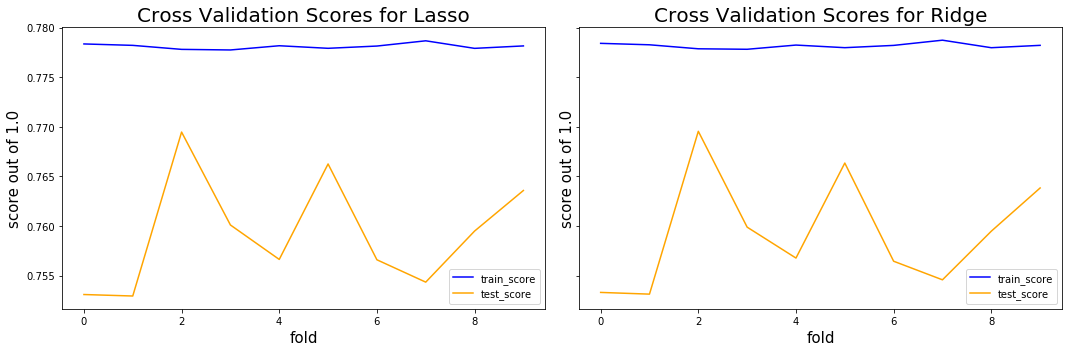

In [130]:
graph_cv_results(bike_lasso_metrics, bike_ridge_metrics)

## GridSearch

Because none of the geospatial feature engineering imrpoved the score much, we have determined that the best pre-processing pipeline was the polynomial features section. Therefore, this will be used in a grid search to find the optimal hyper parameters.

In [364]:
ridge_param_grid = {'ridge__alpha':[0,.001,.01,.1,1,10,100,1000]}

In [365]:
ridge_grid_search = GridSearchCV(ridge_pipe_with_poly, param_grid=ridge_param_grid, cv=cv_strategy, return_train_score=True)
ridge_grid_search.fit(X_train, y_train)
print(f'best score: {ridge_grid_search.best_score_}, best parameters: {ridge_grid_search.best_params_}')

best score: 0.7638101575072641, best parameters: {'ridge__alpha': 0.001}


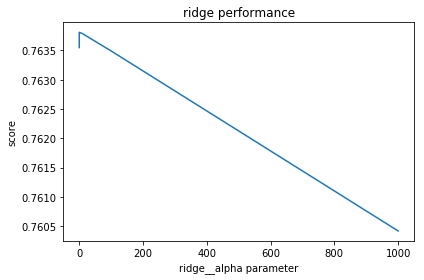

In [366]:
#Ridge performance 
ridge_performance = ridge_grid_search.cv_results_['mean_test_score']
ridge_params = ridge_grid_search.param_grid['ridge__alpha']

plt.plot(ridge_params, ridge_performance)
plt.title("ridge performance")
plt.xlabel("ridge__alpha parameter")
plt.ylabel('score')
plt.tight_layout()

In [414]:
from scipy.stats import randint
import numpy as np
lasso_param_grid = {'lasso__alpha': randint(1,1000)}

In [415]:
lasso_random_search = RandomizedSearchCV(lasso_pipe_with_poly, param_distributions=lasso_param_grid, cv=cv_strategy, n_iter=50, return_train_score=True)
lasso_random_search.fit(X_train, y_train)
lasso_random_search.best_score_
print(f'best score: {lasso_random_search.best_score_}, best parameters: {lasso_random_search.best_params_}')

best score: 0.7565997444797805, best parameters: {'lasso__alpha': 48}


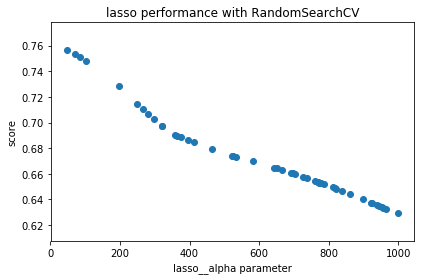

In [417]:
#Lasso performance 
lasso_performance = lasso_random_search.cv_results_['mean_test_score']
lasso_params = lasso_random_search.cv_results_['param_lasso__alpha'].data

plt.scatter(lasso_params, lasso_performance)
plt.title("lasso performance with RandomSearchCV")
plt.xlabel("lasso__alpha parameter")
plt.ylabel('score')
plt.tight_layout()

Ridge and Lasso are approximately equal in performance, with Ridge being a slightly higher performer. Thus, our best linear model is Ridge with an alpha of 0.001 and the poly_processing_pipe which utilizes polynomial features.

## Task 4

For the tree based models, the following changes were made for preprocessing:
- Scaling done on features above was removed as it is not required for tree-based models
- Polynomial Feature interactions were also removed

### Comparing pre-processing methods for trees.

In [23]:
ordinal_cols_mapping = [{
    "col":"cylinders",    
    "mapping": {
        '12 cylinders': 7, 
        '10 cylinders': 6, 
        '8 cylinders': 5, 
        '6 cylinders': 4, 
        '5 cylinders': 3, 
        '4 cylinders': 2,
        '3 cylinders': 1,
        'other': 0
    }},
    {"col":"condition",
     "mapping": {
         'new': 5,
         'like new': 4,
         'excellent': 3,
         'good': 2,
         'fair': 1,
         'salvage': 0
     }},
    {"col":"size",
     "mapping": {
         'full-size': 3,
         'mid-size': 2,
         'compact': 1,
         'sub-compact': 0
    }},
    {"col":"title_status",
     "mapping": {
         'dean': 0,
         'lein': 1,
         'rebuilt': 2,
         'salvage': 3,
         'parts only': 4,
         'missing': 5
    }
}]
to_ordinal_encode = ['cylinders', 'condition', 'size', 'title_status']
data_obj_refined = [x for x in data_obj_refined if x not in to_ordinal_encode]

In [71]:
# Use 'auto' for max_features such that max_features == number of features, as needed for regression
random_forest_reg = RandomForestRegressor(random_state=0, 
                                          max_features = 'auto',
                                          bootstrap='True')

In [25]:
data_obj_refined.extend(target_encode)
data_obj_refined.extend(to_ordinal_encode)

### Onehot + target + ordinal encoding

In [53]:
to_ordinal_encode = ['cylinders', 'condition', 'size']
data_obj_refined = [x for x in data_obj_refined if x not in to_ordinal_encode]

target_encoding = make_pipeline(TargetEncoder())
cat_encoding = Pipeline([('encode', preprocessing.OneHotEncoder(handle_unknown='ignore'))]) 
ordinal_encoding = make_pipeline(OrdinalEncoder(mapping=ordinal_cols_mapping))

tree_pipe = make_column_transformer((target_encoding, target_encode),
                                    (ordinal_encoding, to_ordinal_encode),
                                    (cat_encoding, data_obj_refined), 
                                    remainder='passthrough')
rf_pipe = make_pipeline(tree_pipe, random_forest_reg)
scores = cross_val_score(rf_pipe, X_train, y_train, cv=cv_strategy)
np.mean(scores)

0.8615812147967392

Encoding the categorical variables using one-hot encoding, target encoding and ordinal encoding as it is fast while also allowing for a fairly high cross-validation score. Therefore, this preprocessing will be used for the tree models going forward.

In [23]:
# Remove any scaling, feature engineeirng as not needed for gradient boost
target_encoding = make_pipeline(TargetEncoder())
cat_encoding = Pipeline([('encode', preprocessing.OneHotEncoder(handle_unknown='ignore'))]) 
ordinal_encoding = make_pipeline(OrdinalEncoder(mapping=ordinal_cols_mapping))
tree_pipe = make_column_transformer((target_encoding, target_encode),
                                    (ordinal_encoding, to_ordinal_encode),
                                    (cat_encoding, data_obj_refined), 
                                    remainder='passthrough')

### Tuning Parameters for random forets

In [46]:
# Parameter tuning trees: Tune number of estimators, depth and 
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
max_depth = [int(x) for x in np.linspace(start = 3, stop = 20, num = 10)]
min_samples_split = [int(x) for x in np.linspace(start = 1, stop = 50, num = 10)]
rf_params = {'randomforestregressor__n_estimators': n_estimators, 
             'randomforestregressor__max_depth': max_depth, 
             'randomforestregressor__min_samples_split': min_samples_split}

In [48]:
rf_pipe = make_pipeline(tree_pipe, RandomForestRegressor(bootstrap='True', random_state=0, max_features='auto'))
rf_random_search = RandomizedSearchCV(rf_pipe, param_distributions=rf_params, cv=cv_strategy, n_jobs=-1, return_train_score=True)
rf_random_search.fit(X_train, y_train)
rf_random_search.best_score_

0.8515371590402477

In [49]:
rf_random_search.best_params_

{'randomforestregressor__n_estimators': 466,
 'randomforestregressor__min_samples_split': 17,
 'randomforestregressor__max_depth': 20}

Use the parameters as benchmarks for parameter values. While adding trees will always help with the model's performance, it may add computational complexity (and a larger model) for diminishing returns. Therefore, prune the tree while removing the number of ensembles found through cross validation. Furthermore, use max_features = number_of_features (i.e 'auto') as considered optimal for random forest regressors.

In [21]:
rf = RandomForestRegressor(n_estimators=400, 
                           bootstrap='True', 
                           max_features='auto', 
                           random_state=0, 
                           min_samples_split = 17, 
                           max_depth = 20)

In [73]:
rf_pipe = make_pipeline(tree_pipe, rf)

In [163]:
scores = cross_val_score(rf_pipe, X_train, y_train, cv=cv_strategy)
np.mean(scores)

0.8529102558520023

### Tuning parameters for gradient boosting

As gradient boosting may overfit, tune learning_rate (with the set number of 500 estimators), max_depth, subsample, and max_features to properly apply regularization and prevent overfitting.

In [53]:
n_estimators = 500
learning_rate = [x for x in np.linspace(start = 0.01, stop = 1, num = 10)]
max_depth = [int(x) for x in np.linspace(start = 3, stop = 20, num = 10)]
subsamples = [x for x in np.linspace(start = 0.10, stop= 1, num = 10)]
max_features = ['auto', 'sqrt', 'log2']
gb_params = {'gradientboostingregressor__learning_rate': learning_rate, 
             'gradientboostingregressor__max_features': max_features,
             'gradientboostingregressor__subsample': subsamples,
             'gradientboostingregressor__max_depth': max_depth}

In [55]:
gb_pipe = make_pipeline(tree_pipe, GradientBoostingRegressor(random_state=0, n_estimators=n_estimators))
gb_random_search = RandomizedSearchCV(gb_pipe, param_distributions=gb_params, cv=cv_strategy, n_jobs=-1, return_train_score=True)
gb_random_search.fit(X_train, y_train)
gb_random_search.best_score_

0.8499147070536859

In [56]:
gb_random_search.best_params_

{'gradientboostingregressor__subsample': 0.9,
 'gradientboostingregressor__max_features': 'auto',
 'gradientboostingregressor__max_depth': 3,
 'gradientboostingregressor__learning_rate': 0.89}

In [57]:
gb = GradientBoostingRegressor(n_estimators=500,  
                           max_features='auto', 
                           subsample = 0.9,
                           random_state=0, 
                           learning_rate = 0.89,
                           max_depth = 3)

In [58]:
gb_pipe = make_pipeline(tree_pipe, gb)
scores = cross_val_score(gb_pipe, X_train, y_train, cv=cv_strategy)
np.mean(scores)

0.8499147070536859

With all the models seen so far (linear and tree-based in Task 3 and Task 4), the random forest model showes the highest cross-validaiton performance. It will therefore be used on the testset and selected as the best model going forward.

In [65]:
rf_pipe.fit(X_train, y_train)
rf_pipe.score(X_test, y_test)

0.8523284274473739

## Task 5

As the random forest model showed the best performance, it will be further analyzed in Task 5.

Which features are most influential, and which features could be removed without decrease in performance?
Does removing irrelevant features make your model better?

In [26]:
rf_pipe.fit(X_train, y_train)
ohe = preprocessing.OneHotEncoder(handle_unknown='ignore')
ohe.fit_transform(X_train[data_obj_refined])
one_hot_encoded_categories = list(ohe.get_feature_names(data_obj_refined))
all_feature_names = target_encode + to_ordinal_encode + one_hot_encoded_categories + data_float_refined 

### Default feature importances given by model

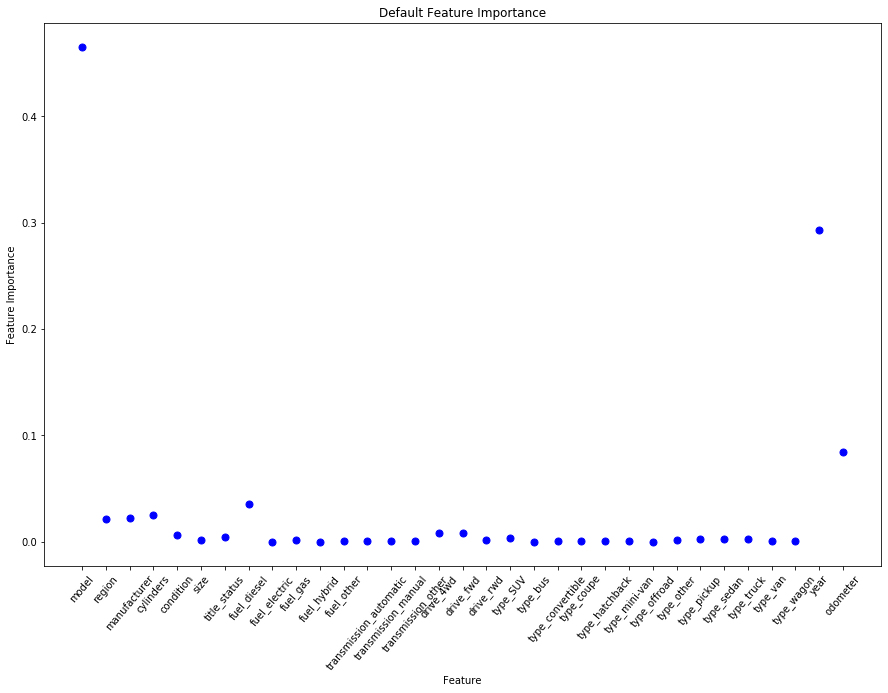

In [109]:
# RF important features
importances = rf_pipe['randomforestregressor'].feature_importances_

fig, ax = plt.subplots(1, 1, figsize=(15,10))
ax.plot(importances, 'bo', markersize=7)
ax.set_xticks(range(len(all_feature_names)))
ax.set_xticklabels(labels=all_feature_names, rotation=50)
ax.set_ylabel('Feature Importance')
ax.set_xlabel('Feature')
ax.set_title('Default Feature Importance')
plt.show()

### Compute Permutation Importances

In [39]:
pi = permutation_importance(rf_pipe, X_train, y_train, n_repeats=10, random_state=0)

In [ ]:
# Zip pi means and column titles together
pi_mean_vals = pi['importances_mean']
cols = X_train.columns
pi_importances_pairs = zip(cols, pi_mean_vals)
pi_pairs_sorted = sorted(pi_importances_pairs, key=lambda x: x[1], reverse=True)

### Importances in decreasing order, as determined by permutation importance

In [47]:
pi_pairs_sorted

[('model', 0.5592220131736731),
 ('year', 0.3997541025709488),
 ('odometer', 0.23546963628804138),
 ('cylinders', 0.07508422367962922),
 ('fuel', 0.07175773467734833),
 ('manufacturer', 0.047608617127821454),
 ('drive', 0.04721875768112562),
 ('region', 0.031195338761682602),
 ('type', 0.02950092360500186),
 ('condition', 0.012992200032476031),
 ('title_status', 0.006864786362616682),
 ('transmission', 0.004197126024664899),
 ('size', 0.0020089050070946635)]

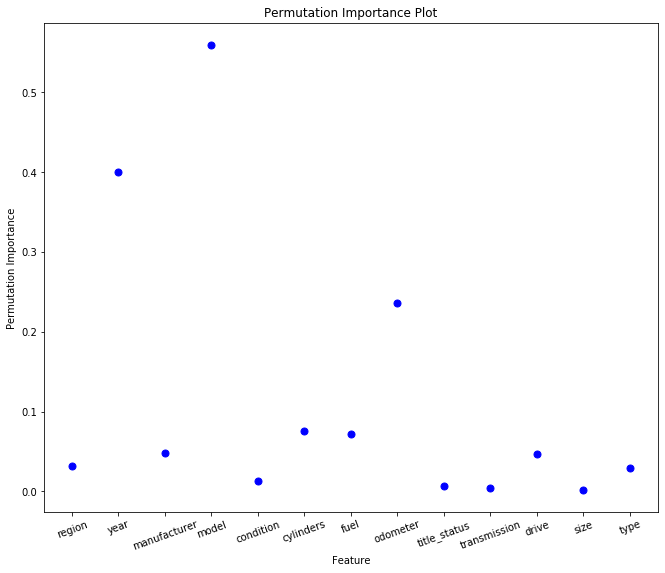

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(11,9))
ax.plot(pi_mean_vals, 'bo', markersize=7)
ax.set_xticks(range(len(X_train.columns)))
ax.set_xticklabels(labels=X_train.columns, rotation=20)
ax.set_ylabel('Permutation Importance')
ax.set_xlabel('Feature')
ax.set_title('Permutation Importance Plot')
plt.show()

### Recursive Feature Elimination

In [124]:
transformed_data_new = pd.DataFrame(tree_pipe_new.fit_transform(X_train, y_train))
selector = RFE(rf_pipe['randomforestregressor'], 1, step=1)
selector = selector.fit(transformed_data_new, y_train)

In [126]:
# ranking_[i] corresponds to the ranking of the ith feature.
ranking_pairs = zip(features, selector.ranking_)
ranking_pairs_sorted = sorted(ranking_pairs, key=lambda x: x[1])

In [127]:
ranking_pairs_sorted

[('model', 1),
 ('year', 2),
 ('odometer', 3),
 ('manufacturer', 4),
 ('fuel', 5),
 ('cylinders', 6),
 ('region', 7),
 ('type', 8),
 ('drive', 9),
 ('condition', 10),
 ('title_status', 11),
 ('transmission', 12),
 ('size', 13)]

### Remove least important features and analyze impact on model

Based on the analysis above, the three features, size, transmision, and title_status were shown to be the most irrelevant feature while the three most influential features included model, year, and odometer. Model, year and odometer had the highest ranking through recursive feature elimination and also the greatest permutation importance. Thus, these three features are the most influential. In contrast, title_status, transmission, and size had the lowest ranking as well as the least permutation important. Size had the smallest ranking and least permutation importance, likely because this column had 69% of the its data missing and therefore, was highly imputed. Thus, size, transmission and title_status will be removed and the model performance will be re-evaluated below.

In [140]:
# Remove irrelevant features and re-evaluate model performance
X_train_irrev_removed = X_train.drop(columns=['title_status', 'transmission', 'size'])

In [141]:
ordinal_cols_mapping_irrev_removed = [{
    "col":"cylinders",    
    "mapping": {
        '12 cylinders': 7, 
        '10 cylinders': 6, 
        '8 cylinders': 5, 
        '6 cylinders': 4, 
        '5 cylinders': 3, 
        '4 cylinders': 2,
        '3 cylinders': 1,
        'other': 0
    }},
    {"col":"condition",
     "mapping": {
         'new': 5,
         'like new': 4,
         'excellent': 3,
         'good': 2,
         'fair': 1,
         'salvage': 0
}}]
to_ordinal_encode_irrev_removed = ['cylinders', 'condition']
data_obj_refined_irrev_removed = [x for x in data_obj_refined if x != 'transmission']

In [142]:
target_encoding = make_pipeline(TargetEncoder())
cat_encoding = Pipeline([('encode', preprocessing.OneHotEncoder(handle_unknown='ignore'))]) 
ordinal_encoding = make_pipeline(OrdinalEncoder(mapping=ordinal_cols_mapping_irrev_removed))
tree_pipe_irrev_removed = make_column_transformer((target_encoding, target_encode),
                                    (ordinal_encoding, to_ordinal_encode_irrev_removed),
                                    (cat_encoding, data_obj_refined_irrev_removed), 
                                    remainder='passthrough')

In [161]:
rf_pipe_irrev_removed = make_pipeline(tree_pipe_irrev_removed, rf)
scores = cross_val_score(rf_pipe_irrev_removed, X_train_irrev_removed, y_train, cv=cv_strategy)
np.mean(scores)

0.8489605020945588

In [164]:
rf_pipe_irrev_removed.fit(X_train_irrev_removed, y_train)
X_test_irrev_removed = X_test.drop(columns=['title_status', 'transmission', 'size'])
rf_pipe_irrev_removed.score(X_test_irrev_removed, y_test)

0.8530924479978621

Based on the cross-validation score above, removing the irrelevant features (title_status, size, and transmission) did not significantly alter the model performance. The overall score did not improve however, remained very similar to the cross-validation score when the irrelevant features were included. This is indicative of these features adding little significance to the model and therefore, can be removed to create a more compact model going forward.

## Task 6

Our best model so far is the random forest classifier shown in section 4. Because section 6 is aiming to crate a more interpretable mdoel, we have used the results of section 5. We will use that model here to create an interpretable model, shown with each feature and its role in decision making. 

Also, in order to make an even more itnerpretable model we used RFE to drop the number of features down to 6. 

Finally, we made an interpretable tree model, however the performance cannot compare to that of the random forest. 

In [219]:
rf = RandomForestRegressor(n_estimators=400, 
                           bootstrap='True', 
                           max_features='auto', 
                           random_state=0, 
                           min_samples_split = 17, 
                           max_depth = 20)

In [220]:
ordinal_cols_mapping_irrev_removed = [{
    "col":"cylinders",    
    "mapping": {
        '12 cylinders': 7, 
        '10 cylinders': 6, 
        '8 cylinders': 5, 
        '6 cylinders': 4, 
        '5 cylinders': 3, 
        '4 cylinders': 2,
        '3 cylinders': 1,
        'other': 0
    }},
    {"col":"condition",
     "mapping": {
         'new': 5,
         'like new': 4,
         'excellent': 3,
         'good': 2,
         'fair': 1,
         'salvage': 0
}}]
to_ordinal_encode_irrev_removed = ['cylinders', 'condition']
data_obj_refined_irrev_removed = [x for x in data_obj_refined if x != 'transmission']

In [222]:
#Drop excess columns
data_obj_refined_irrev_removed.remove('title_status')
data_obj_refined_irrev_removed.remove('size')
data_obj_refined_irrev_removed.remove('cylinders')
data_obj_refined_irrev_removed.remove('condition')

In [243]:
new_target_encode = target_encode + data_obj_refined_irrev_removed
target_encoding = make_pipeline(TargetEncoder())
cat_encoding = Pipeline([('encode', preprocessing.OneHotEncoder(handle_unknown='ignore'))]) 
ordinal_encoding = make_pipeline(OrdinalEncoder(mapping=ordinal_cols_mapping_irrev_removed))
tree_pipe_irrev_removed = make_column_transformer((target_encoding, new_target_encode),
                                    (ordinal_encoding, to_ordinal_encode_irrev_removed),
                                    remainder='passthrough')

In [244]:
rf_pipe_irrev_removed = make_pipeline(tree_pipe_irrev_removed_rfe, rf)

In [245]:
transformed_data_int = pd.DataFrame(tree_pipe_irrev_removed.fit_transform(X_train_irrev_removed, y_train))

In [247]:
rf.fit(transformed_data_int, y_train)

RandomForestRegressor(bootstrap='True', ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=17, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [253]:
percent_importances = [x*100 for x in rf.feature_importances_]

Text(0.5, 0, 'Feature Importance (%)')

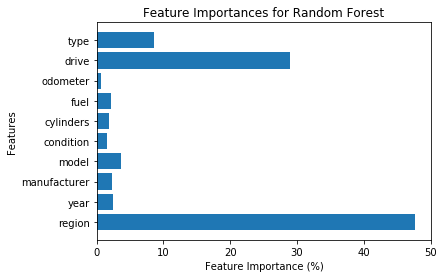

In [257]:
plt.barh(range(10), percent_importances)
plt.title('Feature Importances for Random Forest')
plt.yticks(range(10), X_train_irrev_removed.columns)
plt.ylabel('Features')
plt.xlabel('Feature Importance (%)')

# Using RFE to make an even smaller and more interpretable model

In [189]:
target_encoding = make_pipeline(TargetEncoder())
target_encode_new = target_encode + data_obj_refined_irrev_removed
cat_encoding = Pipeline([('encode', preprocessing.OneHotEncoder(handle_unknown='ignore'))]) 
ordinal_encoding = make_pipeline(OrdinalEncoder(mapping=ordinal_cols_mapping_irrev_removed))
tree_pipe_irrev_removed_rfe = make_column_transformer((target_encoding, target_encode_new),
                                    (ordinal_encoding, to_ordinal_encode_irrev_removed),
                                    remainder='passthrough')

In [190]:
rf_pipe_irrev_removed = make_pipeline(tree_pipe_irrev_removed_rfe, rf)

In [192]:
transformed_data_rfe = pd.DataFrame(tree_pipe_irrev_removed_rfe.fit_transform(X_train_irrev_removed, y_train))

In [84]:
# Using RFE to determine the best features and drop any unnescesary ones 
from sklearn.feature_selection import RFE
rfe = RFE(rf_pipe_irrev_removed['randomforestregressor'], n_features_to_select=1)
rfe.fit(transformed_data_rfe, y_train)
rfe.ranking_

array([ 1,  6,  4,  5,  9,  8,  7, 10,  2,  3])

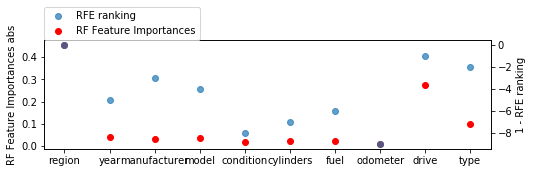

In [194]:
rfr = RandomForestRegressor().fit(transformed_data_rfe, y_train)
fig = plt.figure(figsize=(8, 2))
line_f, = plt.plot(np.abs(rfr.feature_importances_), 'o', c='r')
plt.ylabel("RF Feature Importances abs")
ax2 = plt.twinx()
ax2.set_ylabel("1 - RFE ranking")
line_s, = ax2.plot(1 - rfe.ranking_, 'o', alpha=.7)
plt.xticks(range(transformed_data_rfe.shape[1]), X_train_irrev_removed.columns)
plt.legend([line_s, line_f], ["RFE ranking", "RF Feature Importances"], loc=(0, 1))

Moving forward we will be keeping the following columns:
- region
- drive
- type
- manufacturer
- model
- year

### Reducing features based on previous RFE and graphing the results for interpretability

In [195]:
X_train_rfe_confirmed = X_train_irrev_removed[['region','year','manufacturer','model','drive','type']]
X_test_rfe_confirmed = X_test_irrev_removed[['region','year','manufacturer','model','drive','type']]

In [200]:
data_obj_refined_rfe_irrev_removed = ['year','drive','type']

In [136]:
target_encoding = make_pipeline(TargetEncoder())
target_encode_new = target_encode + data_obj_refined_irrev_removed
cat_encoding = Pipeline([('encode', preprocessing.OneHotEncoder(handle_unknown='ignore'))]) 
ordinal_encoding = make_pipeline(OrdinalEncoder(mapping=ordinal_cols_mapping_irrev_removed))
tree_pipe_interpretable = make_column_transformer((target_encoding, targetencode),
                                    (cat_encoding, data_obj_refined_rfe_irrev_removed), 
                                    remainder='drop')

In [201]:
rf = RandomForestRegressor(n_estimators=400, 
                           bootstrap='True', 
                           max_features='auto', 
                           random_state=0, 
                           min_samples_split = 17, 
                           max_depth = 20)

In [202]:
rf_pipe_interpretabe = make_pipeline(tree_pipe_interpretable, rf)

In [203]:
rf_pipe_interpretabe.fit(X_train_rfe_confirmed, y_train)
rf_pipe_interpretabe.score(X_test_rfe_confirmed, y_test)

0.7809712784194764

In [262]:
transformed_data_int = pd.DataFrame(tree_pipe_interpretable.fit_transform(X_train_rfe_confirmed, y_train))

In [264]:
rf.fit(transformed_data_int, y_train)

RandomForestRegressor(bootstrap='True', ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=17, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

Text(0.5, 0, 'Feature Importance out of 1')

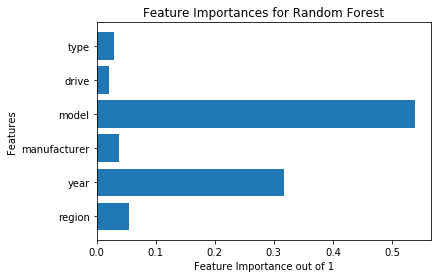

In [215]:
plt.barh(range(6), rf.feature_importances_)
plt.title('Feature Importances for Random Forest')
plt.yticks(range(6), X_train_rfe_confirmed.columns)
plt.ylabel('Features')
plt.xlabel('Feature Importance out of 1')

# Building a very interpretable tree model

In [258]:
from sklearn.tree import DecisionTreeClassifier

In [342]:
dt = DecisionTreeClassifier(max_leaf_nodes = 20)

In [343]:
target_encode_new = list(X_train_rfe_confirmed.columns)

In [344]:
target_encoding = make_pipeline(TargetEncoder())
cat_encoding = Pipeline([('encode', preprocessing.OneHotEncoder(handle_unknown='ignore'))]) 
ordinal_encoding = make_pipeline(OrdinalEncoder(mapping=ordinal_cols_mapping_irrev_removed))
tree_pipe_simple = make_column_transformer((target_encoding, target_encode_new),
                                    remainder='passthrough')

In [345]:
dt_pipe_simple = make_pipeline(tree_pipe_simple, dt)

In [346]:
dt_pipe_simple.fit(X_train_rfe_confirmed, y_train)
dt_pipe_simple.score(X_test_rfe_confirmed, y_test)

0.024340333871836296

In [347]:
dt.fit(transformed_data_int, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=20,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

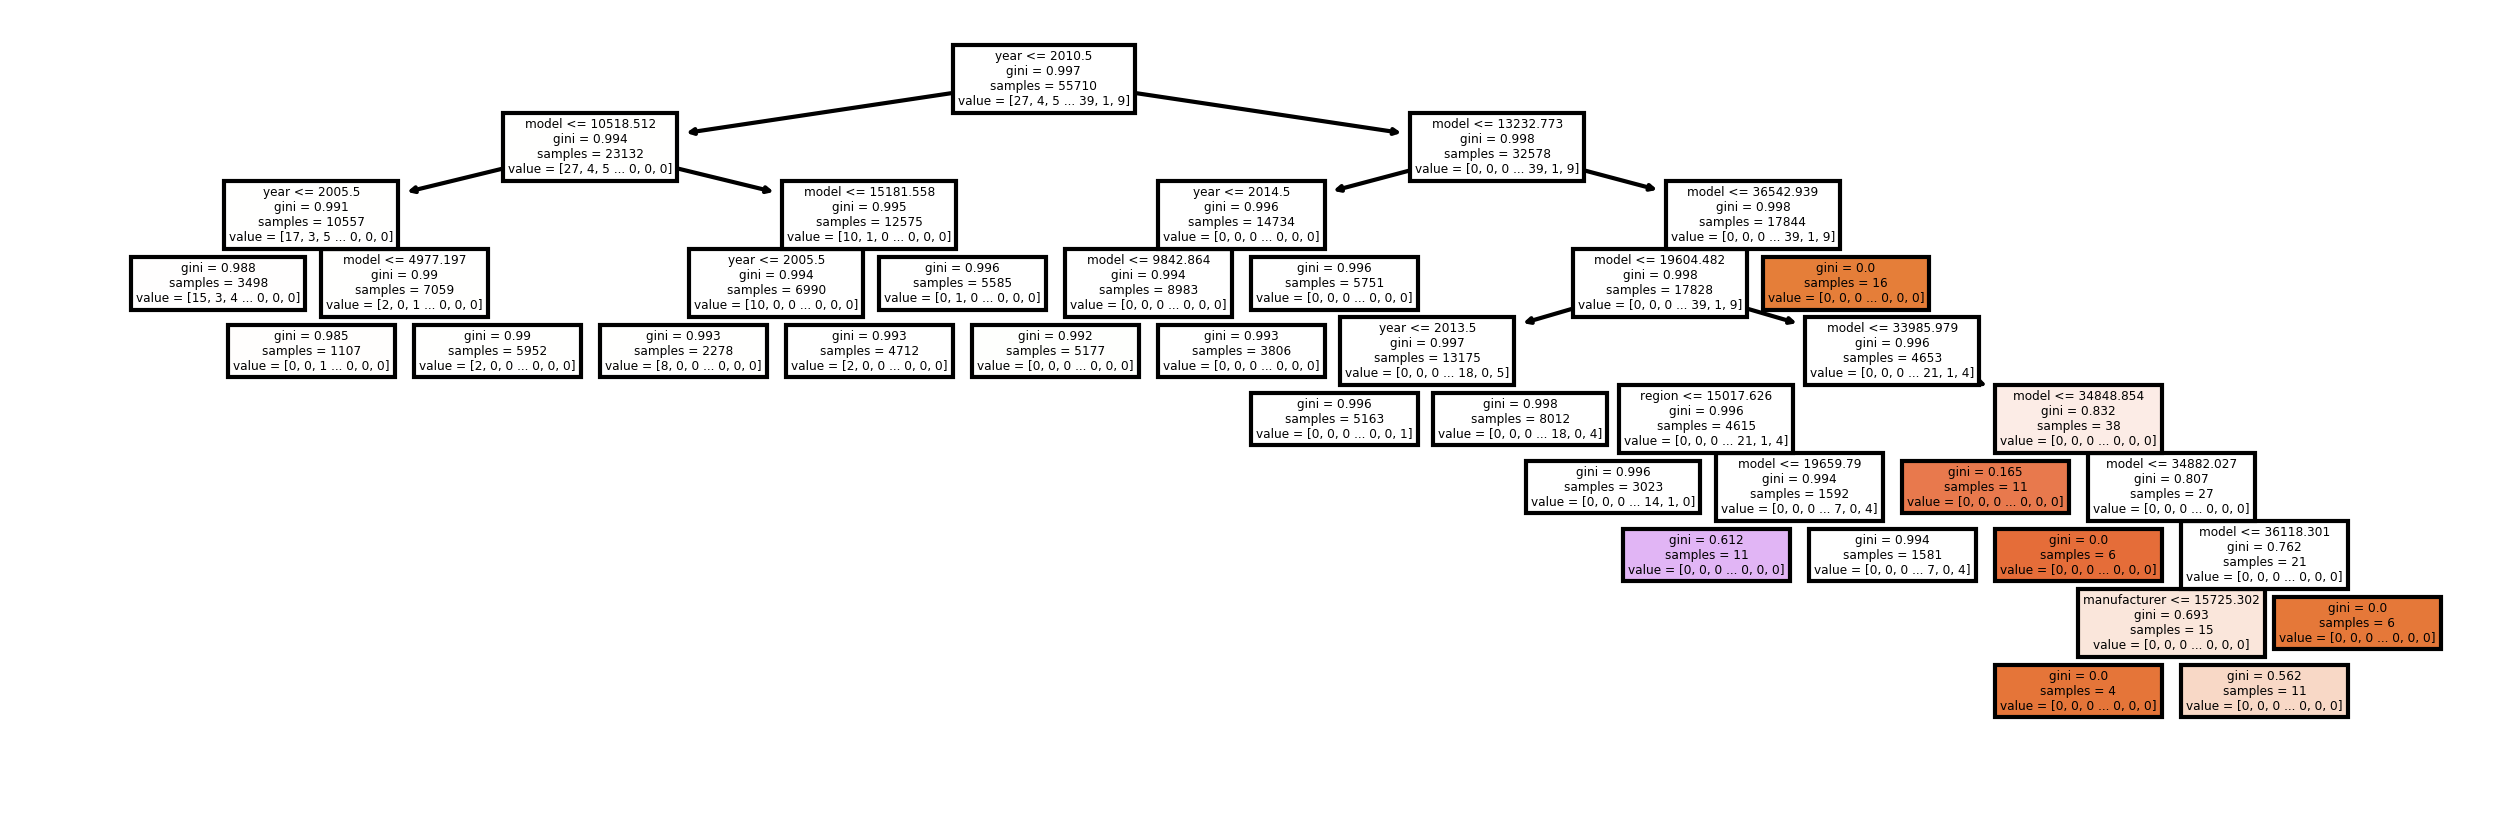

In [349]:
from sklearn.tree import plot_tree
plt.figure(figsize=(10, 3), dpi=300)
tree_dot = plot_tree(dt, feature_names=X_train_rfe_confirmed.columns, filled=True)

Clearly this tree, while interpretable, is not a good choice as it does not perform as well as our other models. Thus, we will now try to build an interpretable linear model below.

## Using RFE on Linear Models 

In [528]:
#new_target_encode = target_encode + data_obj_refined
ordinal_encoding = make_pipeline(OrdinalEncoder(mapping=ordinal_cols_mapping), preprocessing.StandardScaler())
target_encoding = make_pipeline(TargetEncoder(), preprocessing.StandardScaler())
cont_encoding = Pipeline([('scale', preprocessing.StandardScaler())])
rfe_linear_pipe = make_column_transformer((target_encoding, new_target_encode),
                                        (ordinal_encoding, to_ordinal_encode),
                                        (cont_encoding, data_float_refined), 
                                        remainder='passthrough')


In [490]:
linear_rfe_xtrain = pd.DataFrame(rfe_linear_pipe.fit_transform(X_train, y_train))

In [529]:
#Lasso is being used here instead of ridge because we are aiming to drop unimportant features 
optimal_lasso_pipe_with_poly = make_pipeline(rfe_linear_pipe, Lasso(alpha=48))

In [495]:
# Using RFE to determine the best features and drop any unnescesary ones 
linear_rfe = RFE(optimal_lasso_pipe_with_poly['lasso'], n_features_to_select=1)
linear_rfe.fit(linear_rfe_xtrain, y_train)
linear_rfe.ranking_

array([ 1,  7, 11,  4, 12,  6,  8,  5, 10, 13,  9,  2,  3])

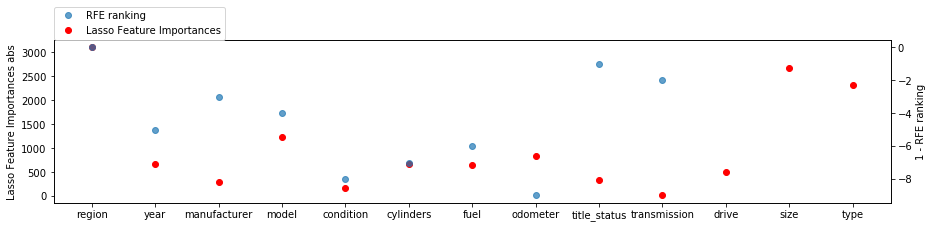

In [506]:
lasso_rfe = Lasso(alpha=48).fit(linear_rfe_xtrain, y_train)
fig = plt.figure(figsize=(15, 3))
line_f, = plt.plot(np.abs(lasso_rfe.coef_), 'o', c='r')
plt.ylabel("Lasso Feature Importances abs")
ax2 = plt.twinx()
ax2.set_ylabel("1 - RFE ranking")
line_s, = ax2.plot(1 - rfe.ranking_, 'o', alpha=.7)
plt.xticks(range(linear_rfe_xtrain.shape[1]), X_train.columns, rotation=45)
plt.legend([line_s, line_f], ["RFE ranking", "Lasso Feature Importances"], loc=(0, 1))

We will build a model with the 6 highest RFE rankings. 

In [507]:
linear_rfe_approved = ['region','year','manufacturer','model','title_status','transmission']

In [527]:
ordinal_cols_mapping = [{
    "col":"title_status",
     "mapping": {
         'dean': 0,
         'lein': 1,
         'rebuilt': 2,
         'salvage': 3,
         'parts only': 4,
         'missing': 5
    }
}]

In [522]:
x_train_linear_rfe = X_train[linear_rfe_approved]
x_test_linear_rfe = X_test[linear_rfe_approved]

In [530]:
optimal_lasso_pipe_with_poly.fit(x_train_linear_rfe, y_train)
optimal_lasso_pipe_with_poly.score(x_test_linear_rfe, y_test)

0.6392165113498931

Text(0.5, 0, 'Feature Importance')

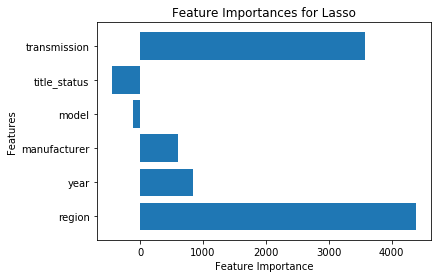

In [543]:
plt.barh(range(6), optimal_lasso_pipe_with_poly['lasso'].coef_)
plt.title('Feature Importances for Lasso')
plt.yticks(range(6), x_train_linear_rfe.columns)
plt.ylabel('Features')
plt.xlabel('Feature Importance')

In [540]:
positive_coef = [abs(x) for x in optimal_lasso_pipe_with_poly['lasso'].coef_]

Text(0.5, 0, 'abs Feature Importance')

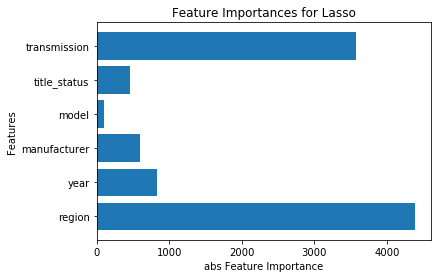

In [542]:
plt.barh(range(6), positive_coef)
plt.title('Feature Importances for Lasso')
plt.yticks(range(6), x_train_linear_rfe.columns)
plt.ylabel('Features')
plt.xlabel('abs Feature Importance')

Because the top value for this linear model was approximately 0.7, a value of 0.639 is not a much worse performing model and using only 6 coefficients makes it much more interpretable. 